# Machine Learning using Best Fourier Coefficients



It is necessary to install pip in your environment and using this, package PyDynamic:*

pip install PyDynamic

*In order to see interactive diagrams, write:* 

pip install ipywidgets

jupyter nbextension enable --py widgetsnbextension   

### Importing the data 

In [1]:
import h5py                                     # Importing the h5 package.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PyDynamic  


C:\Users\jugo01\AppData\Local\Continuum\anaconda3\envs\Zema\lib\site-packages\PyDynamic\identification\fit_filter.py:34: DeprecationWarning: The module *identification* will be combined with the module *deconvolution* and renamed to *model_estimation* in the next major release 3.0. From then on you should only use the new module *model_estimation* instead.
  DeprecationWarning)


In [2]:
from PyDynamic import __version__ as version
version

'1.2.79'

In [3]:
filename = 'Sensor_data_2kHz.h5'                # Data filename.
f = h5py.File(filename, 'r')                    # Importing the h5 file. 

#print("Keys: %s" % f.keys())
a_group_key = list(f.keys())[0]

data = list(f[a_group_key])                     # Transforming data into list

sensorADC=[]                                       # Initialising a list "sensor" and
for i in range(11):                                # Filling it with data from all sensors 
    sensorADC.append(pd.DataFrame(data[i][:][:]))

for i in range(11):                             
    sensorADC[i]=sensorADC[i].iloc[:,:6291]           # Cutting the last cycle because it contains all zero elements.

print("""    
    Input matrices have dimensions: %s, where %s represents number of measurements in time
    and %s represents number of cycles.""" % (np.shape(sensorADC[0]),np.shape(sensorADC[0])[0],np.shape(sensorADC[0])[1]))

    
    Input matrices have dimensions: (2000, 6291), where 2000 represents number of measurements in time
    and 6291 represents number of cycles.


### Converting into SI units 

In [4]:
offset=[0, 0, 0, 0, 0.00488591, 0.00488591, 0.00488591,  0.00488591, 1.36e-2, 1.5e-2, 1.09e-2]
gain=[5.36e-9, 5.36e-9, 5.36e-9, 5.36e-9, 3.29e-4, 3.29e-4, 3.29e-4, 3.29e-4, 8.76e-5, 8.68e-5, 8.65e-5]
b=[1, 1, 1, 1, 1, 1, 1, 1, 5.299641744, 5.299641744, 5.299641744]
k=[250, 1, 10, 10, 1.25, 1, 30, 0.5, 2, 2, 2]
units=['[Pa]', '[g]', '[g]', '[g]', '[kN]', '[bar]', '[mm/s]', '[A]', '[A]', '[A]', '[A]']

sensor=[0]*len(sensorADC)

for i in range(len(sensorADC)):
    sensor[i]=((sensorADC[i]*gain[i])+offset[i])*b[i]*k[i]


###### If you have problems with previous step, you can skip conversion into SI units by running next cell.

In [ ]:
sensor=sensorADC

### Splitting data into training and testing data

Lifetime is represented with percentage values where 0 % means being brand-new and 100 % being broken. Firstly, target vector is created, which assumes linear correlation between cycle number and the degree of wear of the electro-mechanical cylinder.

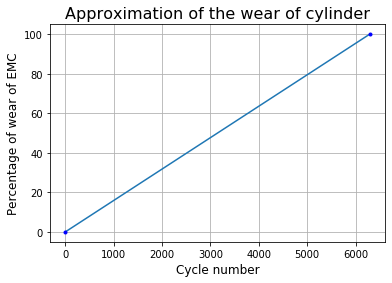

In [5]:
# Creating a target vector which will be used for correlation analysis.

target=list(np.zeros(6291))          # Making the target list which takes into account number of cycles, which-
for i in range(6291):                # goes from 0 to 100, and has number of elements same as number of cycles. 
    target[i]=(i/6290)*100

target_matrix = pd.DataFrame(target)        # Transforming list "target" into data frame "target matrix "
plt.plot(target_matrix.index.values, target_matrix.values)
plt.title("Approximation of the wear of cylinder", fontsize=16)
plt.xlabel("Cycle number", fontsize=12)
plt.ylabel("Percentage of wear of EMC", fontsize=12)
plt.grid()
plt.plot(6291, 100, '.', color='b')
plt.plot(0, 0, '.', color='b')

Now we need to split the raw data into training and testing data sets.
For that purpose, we use scikit.learn function `train_test_split` which will, in this case, choose randomly k % of the cycles into training data, and the rest of it will be used for testing. Function `train_test_split` is applied on target vector, and based on a selected cycles for training and testing in target vector, those same cycles are extracted from the data set `"sensor"`.

So, after this step main data to work on are lists: 

"sensor_train" with their class labels "train_target"
 
and 
 
"sensor_test" with their class labels "test_target"

In [6]:
from sklearn.model_selection import train_test_split

k = int(input("Enter the percentage which will be used as a traning data (recommended is 80-90): "))
target_train_vector, target_test_vector =train_test_split(target_matrix, test_size=1-k/100.)

print("\nNumber of cycles selected for traning is: ", target_train_vector.shape[0],",")
print("and number of cycles selected for testing is: ", target_test_vector.shape[0])

target=list(target_train_vector[0])


C:\Users\jugo01\AppData\Local\Continuum\anaconda3\envs\Zema\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\jugo01\AppData\Local\Continuum\anaconda3\envs\Zema\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


Enter the percentage which will be used as a traning data (recommended is 80-90): 85

Number of cycles selected for traning is:  5347 ,
and number of cycles selected for testing is:  944


In [7]:
sensor_train=[0]*11
sensor_test=[0]*11

for i in range(11):
    sensor_train[i]=sensor[i].loc[:,target_train_vector.index]

print("Traning data for one sensor has dimensions: ", sensor_train[10].shape,",      ('sensor_train') ")
print("and it's target vector has length: ", target_train_vector.shape,",               ('target_train_vector') \n")

for i in range(11):
    sensor_test[i]=sensor[i].loc[:,target_test_vector.index]

print("Testing data for one sensor has dimensions: ", sensor_test[10].shape,",      ('sensor_test') ")
print("and it's target vector has length: ", target_test_vector.shape,",        ('target_test_vector') \n")

Traning data for one sensor has dimensions:  (2000, 5347) ,      ('sensor_train') 
and it's target vector has length:  (5347, 1) ,               ('target_train_vector') 

Testing data for one sensor has dimensions:  (2000, 944) ,      ('sensor_test') 
and it's target vector has length:  (944, 1) ,        ('target_test_vector') 



In [8]:
train_test= h5py.File("Train_test_data_split","w")

train_test["target_train_vector"]=target_train_vector.to_numpy()
train_test["target_test_vector"]=target_test_vector.to_numpy()
train_test.close()
        

In [9]:
train_test= h5py.File("Train_test_data_split_dataframe","w")

train_test["target_train_vector"]=target_train_vector
train_test["target_test_vector"]=target_test_vector
train_test.close()

We can have a look at the data from one sensor after splitting for better understanding of structure for next steps. Number of rows is 2000 and each column is one random measurement cycle. Table shows only first five samples in time (five rows) for each cycle. 

In [ ]:
sensor_train[0].head()

###  Fast Fourier transform

###### Steps:  
    
- transformation into frequency domain (FFT)
- choose amplitudes with highest average absolute value (the top 10%)


In this method of feature extraction, data is transformed into frequency domain using FFT function for discrete Fourier transform. More detail about FFT in [1_FFT_and_Reconstruction.ipynb](1_FFT_and_Reconstruction.ipynb)

This step is an unsupervised extraction method (i.e. is done without knowledge of the cycle‘s group affiliation) and used is to reduce dimension for further steps.






###### A function is created, which takes as input: 
- data from one sensor `sensor`,                                 
- number of samples `n_of_samples`,                                    
- percentage of data to choose `N`.

Function does fast Fourier transform and chooses N% of sprectrum with highest average of absolute values for each sensor independently. Average of absolute values for one frequency is calculated through all cycles.                                   


###### Function returns:
- `freq_of_sorted_values` matrix sized [1, N% of features (amplitudes)] where elements are frequencies which are choosen and they are labels for second output from this function.
- `sorted_values_matrix` sized [number of cycles, N% of features (amplitudes)] where row represents one cycle and columns are sorted by the average of absolute vales for each frequency (column).

In [10]:
def chooseAndReturnOrdered(sensor, n_of_samples, N): 
    x_measurements=range(sensor.shape[0])                 # Number of measurements samples in time period.
    x = np.true_divide(x_measurements, n_of_samples)      # Time values, used  as real time axis.
    freq = np.fft.rfftfreq(x.size, 0.0005)                # Frequency axis, can be used for ploting in frequency domain.
    fft_amplitudes = np.fft.rfft(sensor,n_of_samples,0)   # Ndarray of amplitudes after fourier transform.
    fft_matrix = pd.DataFrame(fft_amplitudes)             # Transforming amplitudes into data frame (matrix)-
                                                          # -where one column represents amplitudes of one-
                                                          # -cycle.
    fft_matrix=fft_matrix.transpose()                     # Transposing to matrix where rows are cycles.
    n_rows, n_columns = np.shape(fft_matrix)

    print("\nNumber of cycles is: %s, and number of features is: %s" % (n_rows, n_columns))
    fft_matrix.columns = freq                    # Column labels are frequencies. 
    
    # Calculating the average of absolute vales for each frequency (column).
    absolute_average_values_from_columns=(np.abs(fft_matrix)).mean()
    
    # Sorting the fft_matrix by the average of absolute vales for each frequency (column).
    fft_matrix=fft_matrix.reindex((np.abs(fft_matrix)).mean().sort_values(ascending=False).index, axis=1)
    
    # Taking first N percent columns from sorted fft_matrix. 
    sorted_values_matrix=fft_matrix.iloc[:,:round((N/100.0)*len(freq))]
    
    n_rows, n_columns = np.shape(sorted_values_matrix)
    print("\nNumber of cycles is: %s, and number of selected features is: %s" % (n_rows, n_columns))
    print(np.shape(sorted_values_matrix))
    
    # Informations about the selected frequencies are columns in sorted data frame. 
    freq_of_sorted_values=(pd.DataFrame(sorted_values_matrix.columns)).transpose()
    print("\nFirst 10 selected frequencies are:\n\n %s" % freq_of_sorted_values.values[:,:10])
    
    sorted_values_matrix.columns=range(round((N/100.0)*len(freq))) # Resetting the column labels.
    print("---------------------------------------------------------------------------------\n")
    # Output "sorted_values_matrix" is data frame whose rows-
    # -are cycles and columns are selected frequencies. For example,- 
    # -value at position (i,j) is amplitude for frequency j in cycle i.
    
    return freq_of_sorted_values, sorted_values_matrix;


###### Function execution

User is asked to define how many of features from frequency domain will be extracted in this step. Then, the function is executed for each sensor and extracted data is stored in 2 lists containing data frames mentioned above. Lists `freq_of_sorted_values` and `sorted_values_from_all_sensors` store function outputs and further selection of features is continued on list `sorted_values_from_all_sensors`. Informations about frequency are going to be used in for feature extraction from testing data, because these frequencies are pattern learned from training data and used for selecting from the testing data or some new data which need to be predicted. 
For all sensors, selected frequencies with most dominant amplitudes are listed as output.

In [21]:
n_of_samples=np.shape(sensor_train[0])[0]

N = int(input("Optimal and recommended percentage of features for this dataset is 10. \n\nEnter a percentage of features: "))
print("\n\n")
# Initialising the list woth 11 elements, which are data frames "sorted_value_matrix" from each sensor.
freq_of_sorted_values=[0]*len(sensor_train)
sorted_values_from_all_sensors=[0]*len(sensor_train)

for i in range(len(sensor_train)):                     
    print("Sensor number %s" % i)
    print("---------------------------------------------------------------------------------")
    freq_of_sorted_values[i],sorted_values_from_all_sensors[i]=chooseAndReturnOrdered(sensor_train[i], n_of_samples, N)

Optimal and recommended percentage of features for this dataset is 10. 

Enter a percentage of features: 10



Sensor number 0
---------------------------------------------------------------------------------

Number of cycles is: 5347, and number of features is: 1001

Number of cycles is: 5347, and number of selected features is: 100
(5347, 100)

First 10 selected frequencies are:

 [[  0. 480.  85.   1. 640. 100.   2. 120.   3.   6.]]
---------------------------------------------------------------------------------

Sensor number 1
---------------------------------------------------------------------------------

Number of cycles is: 5347, and number of features is: 1001

Number of cycles is: 5347, and number of selected features is: 100
(5347, 100)

First 10 selected frequencies are:

 [[480.  80. 479.  79. 481.   2.  78.   0.  40. 120.]]
---------------------------------------------------------------------------------

Sensor number 2
-----------------------------------------------

In [17]:
import os
import h5py

amp_fft= h5py.File("Sorted_vaules_from_all_sensors.hdf5","w")
for s in range(len(sensor)):
    amp_fft["sorted_values_from_all_sensors"+str(s)]=sorted_values_from_all_sensors[s].to_numpy()
amp_fft.close()
        
freq_fft= h5py.File("Sorted_freq_from_all_sensors.hdf5","w")    
for s in range(len(sensor)):
    freq_fft["freq_of_sorted_values"+str(s)]=freq_of_sorted_values[s].to_numpy()
freq_fft.close()


_Example of features extracted from microphone with the best Fourier coefficients method._

Features are complex numbers, because output from the Fourier transform is resulting with amplitudes and phase shifts. For methods used here, amplitudes are more important than phase shifts, and features that will be used are absolute values of amplitudes.  

_Example of frequency labels for features extracted from microphone with the best Fourier coefficients method._

In [12]:
freq_of_sorted_values[0]

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.0,480.0,85.0,1.0,640.0,100.0,2.0,120.0,3.0,6.0,...,149.0,25.0,86.0,759.0,839.0,128.0,838.0,407.0,68.0,803.0


Example. We will take first sensor, which is microphone, as an example. The most dominant frequancy for microphone is 0 Hz, and then 480 Hz. That can be seen in `freq_of_sorted_values[0]`. First two columns in `sorted_values_from_all_sensors[0]` are  amplitudes through all measurement cycles for frequencies 0 and 480 Hz, respectively. 

# START
### Discrete Fourier Transform

In order to include uncertainties in features extraction using BFC, the following is going to be conducted:
    
- transformation into frequency domain (DFT)
- extraction of amplitudes with highest average absolute value (the top 10%), with corresponding phases and uncertainties.

The results of DFT are obtained by using function `Time2AmpPhase_multi`. Function is executed with uncertainties presented in sparse matrix in order to avoid memory errors during calculation for high number of cycles.The usage of sparse matrix is possible since most of covariance values are zeros. 

###### Function returns:
- ` A` np.ndarray sized (M,N) where elements are amplitudes of time domain signals of length N in frequency domain for M cycles. 
- ` P` np.ndarray sized (M,N) where elements are phases of time domain signals of length N in frequency domain for M cycles. 
-  `UAP`np.ndarray sized (M, 3N) where elements are squared standard uncertainties of amplitudes and phases and their covariances for M cycles.


In [13]:


from PyDynamic.uncertainty.propagate_DFT import GUM_DFT
from PyDynamic.uncertainty.propagate_DFT import DFT2AmpPhase
def Time2AmpPhase_multi(x, Ux, selector=None):
    #"""Transformation from time domain to amplitude and phase for a set of M signals of the same type
    # Parameters
    # x: np.ndarray of shape (M,N)
    # M time domain signals of length N
    # Ux: np.ndarray of shape (M,)
    # squared standard deviations representing noise variances of the signals x
    # selector: np.ndarray of shape (L,), optional
    # indices of amplitude and phase values that should be returned; default is 0:N-1
    # Returns
    
    # A: np.ndarray of shape (M,N)
    # amplitude values
    # P: np.ndarray of shape (M,N)
    # phase values
    # UAP: np.ndarray of shape (M, 3N)
    # diagonals of the covariance matrices: [diag(UPP), diag(UAA), diag(UPA)]
    
    M, nx = x.shape
    assert(len(Ux)==M)
    N = nx//2+1
    if not isinstance(selector, np.ndarray):
        selector = np.arange(nx//2+1)
    ns = len(selector)

    A = np.zeros((M,ns))
    P = np.zeros_like(A)
    UAP = np.zeros((M, 3*ns))
    CxCos = None
    CxSin = None
    for m in range(M):
        F, UF, CX = GUM_DFT(x[m,:], Ux[m], CxCos, CxSin, returnC=True)
        CxCos = CX["CxCos"]
        CxSin = CX["CxSin"]
        A_m, P_m, UAP_m = DFT2AmpPhase(F, UF, keep_sparse=True)
        A[m,:] = A_m[selector]
        P[m,:] = P_m[selector]
        UAP[m,:ns] = UAP_m.data[0][:N][selector]
        UAP[m,ns:2*ns] = UAP_m.data[1][UAP_m.offsets[1]:2*N+UAP_m.offsets[1]][selector]
        UAP[m, 2*ns:] = UAP_m.data[0][N:][selector]
        
    return A, P, UAP

Amplitudes are sorted through all cycles and  10% of the highest ones were extracted. Phases and uncertainties are sorted in the way to follow the sorting method for amplitudes. The values are corresponding to the values of 10% chosen amplitudes.
###### Function `chooseAndReturnOrdered_with_uncertainty` returns:
- `freq_of_sorted_values` matrix sized [1, N% of features (amplitudes)] where elements are frequencies which are choosen and they are labels for second output from this function.
- `sorted_values_amp` sized [number of cycles, N% of features (amplitudes)] where row represents one cycle and columns are sorted by the average of absolute values of amplitudes for each frequency (column).
- `sorted_values_phases` - sized [number of cycles, N% of features (phases)] where row represents one cycle and columns of phases are sorted by the absolute values of amplitudes  for each frequency (column). 
- `sorted_values_uncert_aa` - sized [number of cycles, N% of features (uncertainties)] where row represents one cycle and columns of squared standard uncertainties for amplitudes are sorted by the average of absolute vales for each frequency (column). 
- `sorted_values_uncert_ap` - sized [number of cycles, N% of features (uncertainties)] where row represents one cycle and columns of covariances for amplitudes and phases are sorted by the average of absolute vales for each frequency (column). 
- `sorted_values_uncert_pp`  - sized [number of cycles, N% of features (uncertainties)] where row represents one cycle and columns of squared standard uncertainties for phases are sorted by the average of absolute vales for each frequency (column). 

In [30]:
from PyDynamic.uncertainty.propagate_DFT import GUM_DFT
from PyDynamic.uncertainty.propagate_DFT import DFT2AmpPhase

def chooseAndReturnOrdered_with_uncertainty(sensor, n_of_samples, N,sigma):
    
    x_measurements=range(sensor.shape[0])        
    n_of_samples=np.shape(sensor)[0]                            # number of sampling points
    x = np.true_divide(x_measurements, n_of_samples)            # time steps 
    freq=PyDynamic.uncertainty.propagate_DFT.GUM_DFTfreq(x.size, 0.0005)
    ux=np.ones(sensor.shape[1])*sigma**2
    a,b,c=Time2AmpPhase_multi(sensor.values.transpose(),ux)
    a=pd.DataFrame(a) #amplitudes (M,N)
    b=pd.DataFrame(b) #phases (M,N)
    c=pd.DataFrame(c) #uncertainties (M,3*N)
    a.columns = freq                    # Column labels are frequencies. 
    n_rows, n_columns=a.shape
    print("\nNumber of cycles is: %s, and number of features is: %s" % (n_rows, n_columns))
    # Calculating the average of absolute vales for each frequency (column).
    absolute_average_values_from_columns=np.abs(a.mean())
    # Sorting column indices in amplitudes for sorting phases and uncertainties
    sorted_columns=np.argsort(absolute_average_values_from_columns)[::-1]
    # Uncertaintites have one dimension larger than amplitudes and phases. 
    # Columns indices(len(a):3*len(a) to follow the sorting)
    sorted_columns_unc_ap=(sorted_columns+a.shape[1])
    sorted_columns_unc_pp=(sorted_columns+a.shape[1]*2)
    sorted_columns_unc=np.concatenate((sorted_columns,sorted_columns_unc_ap,sorted_columns_unc_pp))#sorted indices for uncertainties
    # Reindexing all matrices based on columns.
    a=a.reindex((np.abs(a)).mean().sort_values(ascending=False).index, axis=1)
    b=b.reindex(columns=sorted_columns)
    c=c.reindex(columns=sorted_columns_unc)
    # Taking first N percent columns from sorted amplitudes,phases and ucertainties. 
    sorted_values_amp=a.iloc[:,:round((N/100.0)*len(freq))]
    sorted_values_phases=b.iloc[:,:round((N/100.0)*len(freq))] 
    sorted_values_uncert_aa=c.iloc[:,:round((N/100.0)*len(freq))]
    sorted_values_uncert_ap=c.iloc[:,len(freq):a.shape[1]+round((N/100.0)*len(freq))]
    sorted_values_uncert_pp=c.iloc[:,2*len(freq):a.shape[1]*2+round((N/100.0)*len(freq))]                                             
    n_rows, n_columns = np.shape(sorted_values_amp)
    print("\nNumber of cycles is: %s, and number of selected features is: %s" % (n_rows, n_columns))
    print(np.shape(sorted_values_amp))
    
    # Informations about the selected frequencies are columns in sorted data frame. 
    freq_of_sorted_values=(pd.DataFrame(sorted_values_amp.columns)).transpose()
    print("\nFirst 10 selected frequencies are:\n\n %s" % freq_of_sorted_values.values[:,:10])
    
    # Resetting the column labels.
    sorted_values_amp.columns=range(round((N/100.0)*len(freq)))
    sorted_values_phases.columns=range(round((N/100.0)*len(freq)))
    sorted_values_uncert_aa.columns=range(round((N/100.0)*len(freq)))
    sorted_values_uncert_ap.columns=range(round((N/100.0)*len(freq)))
    sorted_values_uncert_pp.columns=range(round((N/100.0)*len(freq)))

    print("---------------------------------------------------------------------------------\n")
    # Output "sorted_values_matrix" is data frame whose rows-
    # -are cycles and columns are selected frequencies. For example,- 
    # -value at position (i,j) is amplitude for frequency j in cycle i.
    return freq_of_sorted_values,sorted_values_amp,sorted_values_phases,sorted_values_uncert_aa,sorted_values_uncert_ap, sorted_values_uncert_pp
    
   
   

###### Function execution


User is asked to define how many of features from frequency domain will be extracted in this step. Then, the function is executed for each sensor and extracted data is stored in 6 lists containing data frames mentioned above. Lists:
- freq_of_sorted_values
- sorted_values__amp_from_all_sensors 
- sorted_phases_from_all_sensors
- sorted_uncer_from_all_sensors_a
- sorted_uncer_from_all_sensors_ap
- sorted_uncer_from_all_sensors_pp

store function outputs and further selection of features is continued  through loop. 

In [ ]:
#function execution
n_of_samples=np.shape(sensor_train[0])[0]

N = int(input("Optimal and recommended percentage of features for this dataset is 10. \n\nEnter a percentage of features: "))
print("\n\n")
sigma=float(input("Assume standard deviation"))
# Initialising the list woth 11 elements, which are data frames "sorted_value_matrix" from each sensor.
                    
freq_of_sorted_values=[0]*len(sensor_train)
sorted_values__amp_from_all_sensors=[0]*len(sensor_train)
sorted_phases_from_all_sensors=[0]*len(sensor_train)
sorted_uncer_from_all_sensors_a=[0]*len(sensor_train)
sorted_uncer_from_all_sensors_ap=[0]*len(sensor_train)
sorted_uncer_from_all_sensors_pp=[0]*len(sensor_train)

    
for i in range(len(sensor_train)):                     
    print("Sensor number %s" % i)
    print("---------------------------------------------------------------------------------")
    freq_of_sorted_values[i],sorted_values__amp_from_all_sensors[i],sorted_phases_from_all_sensors[i],sorted_uncer_from_all_sensors_a[i],sorted_uncer_from_all_sensors_ap[i],sorted_uncer_from_all_sensors_pp[i]=chooseAndReturnOrdered_with_uncertainty(sensor_train[i], n_of_samples, N,sigma)
    
    
    

Optimal and recommended percentage of features for this dataset is 10. 

Enter a percentage of features: 10



Assume standard deviation0.1
Sensor number 0
---------------------------------------------------------------------------------
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 2.85e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 2.23e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 8.76e-03 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude

DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 2.12e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 9.30e-03 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 3.32e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 2.20e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some ampli

DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 4.11e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 5.60e-03 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 5.33e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 9.78e-03 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some ampli

DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 4.43e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 1.93e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 3.62e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 4.09e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some ampli

The actual minimum value of A/uF is 4.33e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 2.96e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 3.64e-03 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 6.55e-03 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF

DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 9.08e-03 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 2.38e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 5.20e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 4.95e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some ampli

DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 5.95e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 2.21e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 3.67e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 3.17e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some ampli

 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 2.03e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 2.58e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 3.98e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 5.08e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below

DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 1.61e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 2.36e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 4.60e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 2.84e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some ampli

DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 2.45e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 1.84e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 6.08e-03 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 2.04e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some ampli

DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 1.73e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 3.91e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 3.28e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 2.05e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some ampli

DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 2.61e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 1.28e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 6.96e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 4.50e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some ampli

DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 3.26e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 1.62e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 2.12e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 4.42e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some ampli

DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 1.34e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 3.57e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 3.58e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 4.66e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some ampli

DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 2.87e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 1.65e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 2.72e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 3.59e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some ampli

 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 6.01e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 2.57e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 3.01e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 1.66e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below

DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 3.34e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 1.78e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 1.23e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 3.06e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some ampli

DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 9.91e-03 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 2.41e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 6.75e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 5.06e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some ampli

DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 4.46e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 1.26e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 2.84e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 2.41e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some ampli

DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 4.81e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 2.27e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 7.35e-03 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 3.70e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some ampli

DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 3.85e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 1.67e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 2.81e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 2.22e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some ampli

DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 1.16e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 3.58e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 7.09e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 1.71e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some ampli

DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 1.00e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 1.61e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 2.74e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 1.84e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some ampli

DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 2.68e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 3.87e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 2.58e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 3.16e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some ampli

DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 2.36e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 9.60e-03 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 6.07e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 3.18e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some ampli

DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 3.29e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 4.86e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 4.94e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 8.16e-03 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some ampli

DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 7.16e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 4.47e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 6.53e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 4.48e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some ampli

DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 4.56e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 1.42e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 3.13e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 3.47e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some ampli

DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 1.33e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 2.29e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 1.49e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 2.58e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some ampli

DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 3.76e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 2.64e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 1.83e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 2.82e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some ampli

DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 2.52e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 1.43e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 4.39e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 3.51e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some ampli

DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 5.57e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 3.87e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 2.52e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 4.12e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some ampli

DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 1.81e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 1.81e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 4.55e-03 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 3.06e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some ampli

DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 2.71e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 1.23e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 8.51e-03 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 4.17e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some ampli

 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 3.34e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 4.99e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 3.81e-03 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 9.11e-03 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below

DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 3.29e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 2.36e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 4.54e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 1.10e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some ampli

DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 1.63e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 8.47e-03 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 4.54e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 7.59e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some ampli

DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 4.96e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 1.33e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 2.97e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 4.80e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some ampli

DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 3.51e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 1.38e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 4.37e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 1.60e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some ampli

 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 5.03e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 3.34e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 5.72e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 1.75e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below

DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 4.63e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 3.59e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 1.53e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 3.20e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some ampli

 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 2.91e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 1.99e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 5.58e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 7.52e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below

The actual minimum value of A/uF is 2.46e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 9.47e-03 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 2.71e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 3.37e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF

DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 5.48e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 1.43e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 4.06e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 1.48e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some ampli

DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 2.48e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 3.31e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 3.92e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 5.65e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some ampli

DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 2.47e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 3.67e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 2.15e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 2.33e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some ampli

DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 2.33e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 1.75e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 1.85e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 1.03e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some ampli

DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 5.44e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 4.60e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 5.00e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 2.65e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some ampli

DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 6.15e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 8.22e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 1.55e-01 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 5.09e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some ampli

DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 2.51e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 6.26e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 4.03e-02 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 5.62e-03 and the threshold is 1.00e+00
DFT2AmpPhase Warning
 Some ampli

In [23]:
for i in range(len(sensor_train)):
    freq='freq'+str(i)+'.csv'
    amp='amp'+str(i)+'.csv'
    phs='phs'+str(i)+'.csv'
    un_a='un_a'+str(i)+'.csv'
    un_ap='un_ap'+str(i)+'.csv'
    un_pp='un_pp'+str(i)+'.csv'
    freq_of_sorted_values[i].to_csv('C:/Users/jugo01/Desktop/Results/'+freq)
    sorted_values__amp_from_all_sensors[i].to_csv('C:/Users/jugo01/Desktop/Results/'+amp)
    sorted_phases_from_all_sensors[i].to_csv('C:/Users/jugo01/Desktop/Results/'+phs)
    sorted_uncer_from_all_sensors_a[i].to_csv('C:/Users/jugo01/Desktop/Results/'+un_a)
    sorted_uncer_from_all_sensors_ap[i].to_csv('C:/Users/jugo01/Desktop/Results/'+un_ap)
    sorted_uncer_from_all_sensors_pp[i].to_csv('C:/Users/jugo01/Desktop/Results/'+un_pp)
    

In [22]:
freq_of_sorted_values[0]

*Note: When amplitudes are small relative to the uncertainty associated with real and imaginary parts , the GUM uncertainty propagation becomes unreliable and a Monte Carlo method is recommended instead. Consequently, GUM2DFT does raise a warning to the user and recommends using a Monte Carlo method instead whenever an element of  is below a pre-defined threshold. The default threshold in GUM2DFT is 1.0, but may be adjusted for specific applications.[7]*


In [58]:
#Creating HDF5 files:
import os
import h5py

amp_dft= h5py.File("DFTSorted_vaules__from_all_sensors.hdf5","w")
for s in range(len(sensor)):
    amp_dft["sorted_values_amp_from_all_sensors"+str(s)]=sorted_values__amp_from_all_sensors[s].to_numpy()
amp_dft.close()
        
freq_dft= h5py.File("DFTSorted_freq_from_all_sensors.hdf5","w")    
for s in range(len(sensor)):
    freq_dft["freq_of_sorted_values"+str(s)]=freq_of_sorted_values[s].to_numpy()
freq_dft.close()

pp_dft= h5py.File("DFTSorted_ph_from_all_sensors.hdf5","w")    
for s in range(len(sensor)):
    pp_dft["sorted_phases_from_all_sensors"+str(s)]=sorted_phases_from_all_sensors[s].to_numpy()
pp_dft.close()

u_a_dft= h5py.File("DFTSorted_uncer_from_all_sensors_a.hdf5","w")    
for s in range(len(sensor)):
    u_a_dft["sorted_uncer_from_all_sensors_a"+str(s)]=sorted_uncer_from_all_sensors_a[s].to_numpy()
u_a_dft.close()

u_ap_dft= h5py.File("DFTSorted_uncer_from_all_sensors_ap.hdf5","w")    
for s in range(len(sensor)):
    u_ap_dft["sorted_uncer_from_all_sensors_ap"+str(s)]=sorted_uncer_from_all_sensors_ap[s].to_numpy()
u_ap_dft.close()

u_pp_dft= h5py.File("DFTSorted_uncer_from_all_sensors_pp.hdf5","w")    
for s in range(len(sensor)):
    u_pp_dft["sorted_uncer_from_all_sensors_pp"+str(s)]=sorted_uncer_from_all_sensors_pp[s].to_numpy()
u_pp_dft.close()

In [12]:
import os
import h5py

amp_dft1= h5py.File("DFT-Sorted_vaules__from_all_sensors.hdf5","r")
freq_dft1= h5py.File("DFT-Sorted_freq_from_all_sensors.hdf5","r") 
ph_dft1= h5py.File("DFT-Sorted_ph_from_all_sensors.hdf5","r")
u_a_dft1= h5py.File("DFT-Sorted_uncer_from_all_sensors_a.hdf5","r")
u_ap_dft1= h5py.File("DFT-Sorted_uncer_from_all_sensors_ap.hdf5","r")    
u_pp_dft1= h5py.File("DFT-Sorted_uncer_from_all_sensors_pp.hdf5","r")    




OSError: Unable to open file (unable to open file: name = 'DFT-Sorted_vaules__from_all_sensors.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [139]:
freq_of_sorted_values=[0]*len(sensor_train)
sorted_values__amp_from_all_sensors=[0]*len(sensor_train)
sorted_uncer_from_all_sensors_a=[0]*len(sensor_train)
sorted_uncer_from_all_sensors_ap=[0]*len(sensor_train)
sorted_uncer_from_all_sensors_pp=[0]*len(sensor_train)
for i in range(len(sensor)):
    freq_of_sorted_values[i]=freq_dft1["freq_of_sorted_values"+str(i)]
    sorted_values__amp_from_all_sensors[i]=amp_dft1["sorted_values_amp_from_all_sensors"+str(i)]
    sorted_phases_from_all_sensors[i]=ph_dft1["sorted_phases_from_all_sensors"+str(i)]
    sorted_uncer_from_all_sensors_a[i]=u_a_dft1["sorted_uncer_from_all_sensors_a"+str(i)]
    sorted_uncer_from_all_sensors_ap[i]=u_ap_dft1["sorted_uncer_from_all_sensors_ap"+str(i)]
    sorted_uncer_from_all_sensors_pp[i]=u_pp_dft1["sorted_uncer_from_all_sensors_pp"+str(i)]
amp_dft1.close()
freq_dft1.close()
ph_dft1.close()
u_a_dft1.close()
u_ap_dft1.close()
u_pp_dft1.close()

KeyError: "Unable to open object (object 'sorted_uncer_from_all_sensors_pp0' doesn't exist)"

In [68]:
#reading data
freq_of_sorted_values=[0]*len(sensor_train)
sorted_values__amp_from_all_sensors=[0]*len(sensor_train)
sorted_phases_from_all_sensors=[0]*len(sensor_train)
sorted_uncer_from_all_sensors_a=[0]*len(sensor_train)
sorted_uncer_from_all_sensors_ap=[0]*len(sensor_train)
sorted_uncer_from_all_sensors_pp=[0]*len(sensor_train)
for df in range(len(sensor_train)):
    freq='freq'+str(df)+'.csv'
    amp='amp'+str(df)+'.csv'
    phs='phs'+str(df)+'.csv'
    un_a='un_a'+str(df)+'.csv'
    un_ap='un_ap'+str(df)+'.csv'

    un_pp='un_pp'+str(df)+'.csv'
    freq_of_sorted_values[df]=pd.read_csv(r'C:\Users\jugo01\Desktop\\'+freq,index_col=[0])
    sorted_values__amp_from_all_sensors[df]=pd.read_csv(r'C:\Users\jugo01\Desktop\\'+amp,index_col=[0])
    sorted_phases_from_all_sensors[df]=pd.read_csv(r'C:\Users\jugo01\Desktop\\'+phs,index_col=[0])
    sorted_uncer_from_all_sensors_a[df]=pd.read_csv(r'C:\Users\jugo01\Desktop\\'+un_a,index_col=[0])
    sorted_uncer_from_all_sensors_ap[df]=pd.read_csv(r'C:\Users\jugo01\Desktop\\'+un_ap,index_col=[0])
    sorted_uncer_from_all_sensors_pp[df]=pd.read_csv(r'C:\Users\jugo01\Desktop\\'+ un_pp,index_col=[0])  

In [14]:
#reading data
freq_of_sorted_values=[0]*len(sensor_train)
sorted_values__amp_from_all_sensors=[0]*len(sensor_train)
sorted_phases_from_all_sensors=[0]*len(sensor_train)
sorted_uncer_from_all_sensors_a=[0]*len(sensor_train)
sorted_uncer_from_all_sensors_ap=[0]*len(sensor_train)
sorted_uncer_from_all_sensors_pp=[0]*len(sensor_train)
for df in range(len(sensor_train)):
    freq='freq'+str(df)+'.csv'
    amp='amp'+str(df)+'.csv'
    phs='phs'+str(df)+'.csv'
    un_a='un_a'+str(df)+'.csv'
    un_ap='un_ap'+str(df)+'.csv'

    un_pp='un_pp'+str(df)+'.csv'
    freq_of_sorted_values[df]=pd.read_csv(r'C:\Users\Ehlimana\Desktop\Rezultati\\'+freq,index_col=[0])
    sorted_values__amp_from_all_sensors[df]=pd.read_csv(r'C:\Users\Ehlimana\Desktop\Rezultati\\'+amp,index_col=[0])
    sorted_phases_from_all_sensors[df]=pd.read_csv(r'C:\Users\Ehlimana\Desktop\Rezultati\\'+phs,index_col=[0])
    sorted_uncer_from_all_sensors_a[df]=pd.read_csv(r'C:\Users\Ehlimana\Desktop\Rezultati\\'+un_a,index_col=[0])
    sorted_uncer_from_all_sensors_ap[df]=pd.read_csv(r'C:\Users\Ehlimana\Desktop\Rezultati\\'+un_ap,index_col=[0])
    sorted_uncer_from_all_sensors_pp[df]=pd.read_csv(r'C:\Users\Ehlimana\Desktop\Rezultati\\'+ un_pp,index_col=[0])  

An overview of the results:

*Note: Be aware of randomness of splitting data into train and test. Results shown here are for one random split. Functions FFT and DFT were executed for the same split of data.*

In [ ]:
sorted_values__amp_from_all_sensors[0].head(2)

In [ ]:
sorted_uncer_from_all_sensors_a[0].head(2)

In [ ]:
sorted_phases_from_all_sensors[0].head(2)

In [ ]:
sorted_uncer_from_all_sensors_pp[0].head(2)

In [ ]:
sorted_uncer_from_all_sensors_ap[0].head(2)

### Additional: Transformation to time domain for all sensors

Transformation from amplitude and phase to time domain is demonstrated with functions `Reconstruct_time_domain` (on the basis of PyDynamic´s function AmpPhase2Time) and `Reconstruct_time_domain_idft`(on the basis of PyDynamic´s functions AmpPhase2DFT, GUM_iDFT).

First, zero arrays of amplitudes, phases and uncertainties are created (A, P, UAP). Then, function copies values of N% of arguments (amplitudes, phases, u_a, u_ap, u_pp) into column indices (frequencies) of initial zero arrays. 

Function `Reconstruct_time_domain`creates sparse matrix from the values contained in matrices of uncertainties for amplitudes, phases and their covariances, because UAP was previously created from the sparse matrix. For each cycle, function returns:  
- `x` (np.ndarray ) – vector of time domain values and 
- `ux` -  (np.ndarray) – covariance matrix associated with x.


In [ ]:

from scipy.sparse import dia_matrix
from PyDynamic.uncertainty.propagate_DFT import AmpPhase2Time

def Reconstruct_time_domain(N,frequencies,amplitudes,phases,u_a,u_ap,u_pp):
    
    M,num=amplitudes.shape
    length=int(amplitudes.shape[1])*N+1 
    length_2=2*length
    length_3=3*length 
    x=np.zeros((M, length_2-2))
    #storing uncertainties in a list of arrays
    ux=np.zeros((M, length_2-2))
    #predefining A,P,UAP as zero arrays
    A =np.zeros((M, length))
    P= np.zeros((M, length))
    UAP=np.zeros((M, 3*length))
    assert(amplitudes.shape==phases.shape)
    # Indices of columns with highest amplitudes in original matrix (resulted from DFT) are accessible from the
    #sorted frequencies of all sensors
    Index_amplitudes=frequencies[:,:N] 
    # Defining offsets for sparse matrix  
    offset_UAP=[0,length,-length]
     #indices(columns) of 10% highest amplitude values
    Index_amplitudes=Index_amplitudes.astype(int)
    col = np.array(Index_amplitudes[0])
    #Values of 10% highest amplitudes(first N columns of input amplitudes) are copied in A,P,UAP in corresponding indices 
    #of columns. Other columns are zeros. 
    amp_col=np.arange(N)
    A[:, [col]]= amplitudes[:, [amp_col]]
    P[:, [col]]= phases[:, [amp_col]]
    UAP[:,[col]]=u_a[:,[amp_col]]
    UAP[:,[col+length]]=u_ap[:,[amp_col]]
    UAP[:,[col+length_2]]=u_pp[:,[amp_col]]
    for m in range(M): 
        # Defining diagonals for sparse matrix  
        diag1=np.zeros(length_2)
        diag2=np.zeros(length_2)
        diag1[:length]=UAP[m,:length]
        diag1[length:]=UAP[m,length_2:]
        diag3=np.zeros(length_2)
        diag2[offset_UAP[1]:length_2+offset_UAP[1]]=UAP[m][length:length_2] 
        diag3[offset_UAP[1]:length_2+offset_UAP[1]]=UAP[m][length:length_2]
        diagonals =[diag1,diag2,diag3]
        # Creating sparse matrix with three diagonals. Diag1 is the main diagonal.
        Sparse_matr=dia_matrix((diagonals,offset_UAP),shape=((length_2, length_2)))
        X,UX=AmpPhase2Time(A[m,:], P[m,:], Sparse_matr)
        x[m,:] = X
        ux[m,:]=np.diag(UX)
  
    return    x,ux
 

Function `Reconstruct_time_domain_idft` gradually performs transformation from amplitudes and phases to real and imaginary parts and then to time domain, taking into account squared standard uncertainties of amplitudes and phases.  

In [ ]:
from PyDynamic.uncertainty.propagate_DFT import AmpPhase2DFT,GUM_iDFT
import h5py
def Reconstruct_time_domain_idft(N,frequencies,amplitudes,phases,u_a,u_pp):
   
    M,num=amplitudes.shape
    length=int(amplitudes.shape[1])*N+1 #promijeniti index,generisati
    length_2=2*length
    x=np.zeros((M, length_2-2))
    #storing uncertainties in a list of arrays
    ux=np.zeros((M, length_2-2))
    #predefining A,P,UAP as zero arrays
    A =np.zeros((M, length))
    P= np.zeros_like(A)
    UAP=np.zeros((M, length_2)) #UAP contains squared standard uncertainties of amplitudes and phases
    assert(amplitudes.shape==phases.shape)
    # Indices of columns with highest amplitudes
    Index_amplitudes=frequencies[:,:N] #promijeniti index,generisati
    Index_amplitudes=Index_amplitudes.astype(int)
    col = np.array(Index_amplitudes[0])
    #indices(columns) of 10% highest amplitude values
    #first N columns of input amplitudes
    amp_col=np.arange(N)
    A[:, [col]]= amplitudes[:, [amp_col]]
    P[:, [col]]= phases[:, [amp_col]]
    UAP[:,[col]]=u_a[:,[amp_col]]
    UAP[:,[col+length]]=u_pp[:,[amp_col]]
    for m in range(M):
        F,UF=AmpPhase2DFT(A[m,:], P[m,:], UAP[m,:])
        X,UX=GUM_iDFT(F, UF)
        x[m,:] = X
        ux[m,:]=np.diag(UX)
     
    return x,ux
   
    

In [ ]:
for i in range(len(sensor)):
    sorted_values__amp_from_all_sensors[i]=pd.DataFrame(sorted_values__amp_from_all_sensors[i])
    sorted_uncer_from_all_sensors_a[i]=pd.DataFrame(sorted_uncer_from_all_sensors_a[i])
    sorted_phases_from_all_sensors[i]=pd.DataFrame( sorted_phases_from_all_sensors[i])
    sorted_uncer_from_all_sensors_ap[i]=pd.DataFrame(sorted_uncer_from_all_sensors_ap[i])
    sorted_uncer_from_all_sensors_pp[i]=pd.DataFrame(sorted_uncer_from_all_sensors_pp[i])
    freq_of_sorted_values[i]=pd.DataFrame(sorted_uncer_from_all_sensors_pp[i])

###### Function execution

Reconstruction of time domain values for all sensors:

In [ ]:
#function execution
x_time=[0]*len(sensor_train)
ux_time=[0]*len(sensor_train)
N=10 #percentage of amplitudes that were extracted from DFT results
for i in range(len(sensor_train)):                     
    print("Sensor number %s" % i)
    x_time[i],ux_time[i]=Reconstruct_time_domain(N,freq_of_sorted_values[i].values, sorted_values__amp_from_all_sensors[i].values,sorted_phases_from_all_sensors[i].values,sorted_uncer_from_all_sensors_a[i].values,sorted_uncer_from_all_sensors_ap[i].values,sorted_uncer_from_all_sensors_pp[i].values)
    
    

In [ ]:
#function execution
x_time=[0]*len(sensor_train)
ux_time=[0]*len(sensor_train)
for i in range(len(sensor_train)):                     
    print("Sensor number %s" % i)
    x_time[i],ux_time[i]=Reconstruct_time_domain_idft(N,freq_of_sorted_values[i].values, sorted_values__amp_from_all_sensors[i].values,sorted_phases_from_all_sensors[i].values,sorted_uncer_from_all_sensors_a[i].values,sorted_uncer_from_all_sensors_pp[i].values)
       
           

Visualization of time domain signal through all cycles:

In [ ]:



import matplotlib.pyplot as plt
%matplotlib notebook

import ipywidgets as widgets
from ipywidgets import interact, interact_manual
units=['[Pa]', '[g]', '[g]', '[g]', '[kN]', '[bar]', '[mm/s]', '[A]', '[A]', '[A]', '[A]']
labels1 = ['Microphone','Vibration plain bearing','Vibration piston rod','Vibration ball bearing', 'Axial force','Pressure','Velocity','Active current','Motor current phase 1','Motor current phase 2','Motor current phase 3']
def plot_sensor(sensor,cycle):
   
    plt.figure(figsize=(15,12))
    plt.plot(np.arange(0,1,0.0005),sensor_train[sensor].values.transpose()[cycle,:],label="Input time values")
    plt.ylabel(str(units[sensor]))
    plt.xlabel("Time [s]")
    plt.title(str(labels1[sensor]))
    plt.errorbar(np.arange(0,1,0.0005),x_time[sensor][cycle],yerr=np.sqrt((ux_time[sensor][cycle])),label="Reconstructed time values with DFT", ecolor='orangered',
            color='green')
    # Adding legend to the plot    
        

interact(plot_sensor, sensor=range(10),cycle=range(sorted_values__amp_from_all_sensors[0].shape[0]))

In [ ]:
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
units=['[Pa]', '[g]', '[g]', '[g]', '[kN]', '[bar]', '[mm/s]', '[A]', '[A]', '[A]', '[A]']
labels1 = ['Microphone','Vibration plain bearing','Vibration piston rod','Vibration ball bearing', 'Axial force','Pressure','Velocity','Active current','Motor current phase 1','Motor current phase 2','Motor current phase 3']
def plot_sensor1(sensor,cycle):
    plt.figure(figsize=(15,12))
    plt.plot(np.arange(0,1,0.0005),sensor_train[sensor].values.transpose()[cycle,:], label="Input time values")
    plt.ylabel(str(units[sensor]))
    plt.xlabel("Time [s]")
    plt.title(str(labels1[sensor]))
    plt.errorbar(np.arange(0,1,0.0005),x_time[sensor][cycle],yerr=np.sqrt((ux_time[sensor][cycle])),label="Reconstructed time values with DFT", ecolor='orangered',
            color='green')
    # Adding legend to the plot    
    plt.legend(loc='best', frameon=True)
interact(plot_sensor1,sensor=range(10),cycle=widgets.IntSlider(min=0, max=sorted_values__amp_from_all_sensors[0].shape[0], step=1))


## Methods for the feature selection
Results provided from FFT do not contain uncertainties. First method analyzed for the feature selection is Pearson correlation performed on these data.

### 1) Feature selection using Pearson correlation coefficients

After all these unsupervised steps, this step is done with knowledge of cycle‘s group affiliation. Selection is based on a target vector which represents label for each cycle. The method is very simple, Pearson correlation coefficient is calculated between selected features and target vector and it is done for all sensors. After that, number of features with overall highest Pearson correlation coefficients is selected.

#### Pearson correlation

A Pearson correlation is a number between -1 and 1 that indicates the extent to which two variables are linearly related. A correlation coefficient indicates the extent to which dots in a scatterplot lie on a straight line. The stronger the association of the two variables, the closer the Pearson correlation coefficient, r, will be to either +1 or -1 depending on whether the relationship is positive or negative, respectively.

_Pearson correlation formula [3]:_

<img src="pictures/formula1.png">

- $x$ and $y$ are two vectors of length n
- $m_x$ and $m_y$ corresponds to the means of x and y, respectively.

Different relationships and their correlation coefficients are shown in the figure below [4]:

<img src="pictures/Correlation_examples.png">

Firstly, correlation coefficients are calculated for all features and their values are stored in the list `corr`. Then, function called `largest_indices` finds indices for wanted amount of features with highest correlation coefficients. Function output is stored into lists 'sensor_n' and 'feature_n', where element in 'sensor_n' means which sensor, and related element in 'feature_n' means which feature of that sensor is accessed.

Example:
If element in 'sensor_n' is 5, and the element in 'feature_n' at the same position is 50, that means that you can access that feature in this way:

``` python
    sorted_values_from_all_sensors[5].iloc[:][50]
```


Results provided from FFT do not contain uncertainties. First method analyzed for the feature selection is Pearson correlation performed on these data.

In [22]:
from scipy.stats import pearsonr
def Pearson_corr(sorted_values,N,n_of_samples):
    corr=[None]*(len(sorted_values))                     # Making list for correlation coefficients.
    p_value=[None]*(len(sorted_values))

    for j in range(len(sorted_values)):                       # Making sublists in "corr" for each sensor.
        corr[j]=[None]*((round((N/100.0)*n_of_samples/2)))
        p_value[j]=[None]*((round((N/100.0)*n_of_samples/2)))
    
    # Calculating correlation coefficients for each column of each sensor with respect to target.
    for j in range(11):
        for i in range(round((N/100.0)*n_of_samples/2)):
            corr[j][i],p_value[j][i]=pearsonr(np.abs(sorted_values[j][:,i]),target_train_vector[0])

    #matrix_corr_coeff = np.transpose(pd.DataFrame(corr))# Transforming list of correlation coefficients to data frame.
    corr_array=np.array(corr)                                   # Transforming list of correlation coefficients to nparray

    
    return corr_array

In [23]:
def largest_indices(array, n):                               # Function that find indices for 500 biggest Pearson-
    """Returns the n largest indices from a numpy array."""  # -correlation coefficients.
    flat = array.flatten()
    indices = np.argpartition(flat, -n)[-n:]
    indices = indices[np.argsort(-flat[indices])]
    return np.unravel_index(indices, array.shape)  


In [24]:
for i in range(11):
    sorted_values_from_all_sensors[i]=sorted_values_from_all_sensors[i].to_numpy()


#### Function execution

In [25]:
N=10 #percentage of highest amplitudes, see: Machine_Learning_using_Best_Fourier_Coefficients.ipynb
n_of_samples=2000 #number of samples, see: Machine_Learning_using_Best_Fourier_Coefficients.ipynb

n_features_for_select=0
for i in range(len(sorted_values_from_all_sensors)):
   
    n_features_for_select=n_features_for_select+int(len(sorted_values_from_all_sensors[i][0,:]))

# Defining how much of features with biggest Pearson correllation coeff. will be selected.
n_of_features = int(input("How many features out of %s you want to select (recommended is 500): " % n_features_for_select))


target_matrix = pd.DataFrame(target)        # Transforming list "target" into data frame "target_matrix"

print("\nDimension of target matrix is:")
print("                                                 ", target_train_vector.shape)
print("Dimension of amplitude matrix for one sensor is:")
print("                                                 ", sorted_values_from_all_sensors[0][:,:].shape)

corr_array_p=Pearson_corr(sorted_values_from_all_sensors,N,n_of_samples)
print("Array of correlation coefficients has size:")
print("                                                 ",corr_array_p.shape)  
# sensor_n is the index of the sensor number.
# feature_n is the index of the feature number for each sensor number.
sensor_n, feature_n = largest_indices(corr_array_p, n_of_features)

print("Sensor indices of location of features in >sorted_values_from_all_sensors< matrix: \n")
print(sensor_n)
print("\nColumn indices of location of features in >sorted_values_from_all_sensors< matrix: \n")
print(feature_n)

How many features out of 1100 you want to select (recommended is 500): 500

Dimension of target matrix is:
                                                  (5347, 1)
Dimension of amplitude matrix for one sensor is:
                                                  (5347, 100)
Array of correlation coefficients has size:
                                                  (11, 100)
Sensor indices of location of features in >sorted_values_from_all_sensors< matrix: 

[ 7 10 10  8  8  9  2  0  0  1  0  7  2  3  2  2  3  3  1  3  5  9  3  3
  3  9  7  0 10  0  0  2  3  0  0  0  0  2  7  9  5  2  3  7  3  3  3  3
  3  3  0  0  3  3  3  3  0  3  0  2  3  3  2  9  0  3  2  2  0  2  0  2
  7 10  8  2  0  3  2  2  2  2  3  3  3  0  2  3  8  3  3  1  2  0  1  3
  3  3  2  0  9  3  3  0  3  2  0  3 10  2  3  8 10  3  3  3  2  3  0  7
  9  1  0  0  0  7  3  3  1  2  3  1  3 10  3  0 10  0  9  1  2  3  3  7
  1 10  2  2  5 10  7  2  2  2  2  8  2  9  9  2  2 10  3  2  2  2  1  2
  0 10  1  2  7  7  0 

Based on the found indices for highest features, all of them are put together into a list `top_n_features`, but separated into sublists based on the sensor they are taken from. Then, by comparing the sizes of these groups it is shown how many of those selected features are from which sensor.

After that, they are merged into one feature matrix `abs_top_n_together_matrix`, and all steps from here on are done on these features with absolute values.

In [27]:
def percentage (sensor_ind,feature_ind,sorted_values_from_all_sensors):
    # Initialising a list of best features. 11 sublists containing features from each sensor, respectively.
    top_n_features=[[], [], [], [], [], [], [], [], [], [], []]
    for i in range(len(sorted_values_from_all_sensors)):
        for j in range(len(sensor_ind)):
            if sensor_ind[j]==i:
                top_n_features[i].append(sorted_values_from_all_sensors[i][:,feature_ind[j]]);

    for i in range(len(sorted_values_from_all_sensors)):
        for j in range(len(top_n_features[i])):
            top_n_features[i][j]=list(top_n_features[i][j])

    # Merging sublists into one list with all elements.
    top_n_together=[j for i in top_n_features for j in i]  

    top_n_together_matrix=np.transpose(pd.DataFrame(top_n_together))
    print(type(top_n_together_matrix), "\n")

    # Continue working with abosulte values.
    abs_top_n_together_matrix=np.abs(top_n_together_matrix)

    percentage=[None]*(len(sorted_values_from_all_sensors))
    k=0
    for i in range(len(sorted_values_from_all_sensors)):
        #print(top_n_features_matrix.shape)
        print("Number of features from sensor %2.0f is: %3.0f or  %4.2f %%" % (i, len(top_n_features[i]), len(top_n_features[i])/len(sensor_ind)*100))
        percentage[i]=len(top_n_features[i])
        k=k+len(top_n_features[i])/len(sensor_ind)*100
    print("----------------------------------------------------")
    print("                                             %4.2f" % (k))

    return percentage,abs_top_n_together_matrix

In [28]:

abs_top_n_together_matrix=np.zeros((sorted_values_from_all_sensors[0].shape[0], n_features_for_select))
percentage_p,abs_top_n_together_matrix=percentage(sensor_n,feature_n,sorted_values_from_all_sensors)

<class 'pandas.core.frame.DataFrame'> 

Number of features from sensor  0 is:  76 or  15.20 %
Number of features from sensor  1 is:  37 or  7.40 %
Number of features from sensor  2 is:  80 or  16.00 %
Number of features from sensor  3 is:  77 or  15.40 %
Number of features from sensor  4 is:   8 or  1.60 %
Number of features from sensor  5 is:   6 or  1.20 %
Number of features from sensor  6 is:   5 or  1.00 %
Number of features from sensor  7 is:  72 or  14.40 %
Number of features from sensor  8 is:  49 or  9.80 %
Number of features from sensor  9 is:  44 or  8.80 %
Number of features from sensor 10 is:  46 or  9.20 %
----------------------------------------------------
                                             100.00


###  2) Weighted correlation

A weighted correlation allows application of a weight, or relative significance to each value comparison. Correlation comparisons with a higher value for their weight are considered as more significant when compared to the other value comparisons. Weighted correlation requires following arguments:

- x and y are - values being compared.
- w is the weight applied to each comparison. With these arguments, it is possible to calculate:

weighted mean:
$$m(x;w)=\frac {\sum_{i}w_i*x_i}{\sum_{i}w_i}$$ 
weighted covariance:
$$cov(x,y;w)=\frac {\sum _{i}w_i(x_i-m(x;w))(y_i-m(y;w))}{\sum _{i}w_i} $$
weighted correlation:
$$corr(x,y;w)=\frac{cov(x,y;w)}{\sqrt{cov(x,x;w)*cov(y,y;w))}}$$

Correlation is weighted with weight factor:
$$ w_i= \frac {1}{u²({x_i})}$$
where $x_{i}$ represents amplitudes and $u²(x_{i})$ their standard squared uncertainties.

In [ ]:
for i in range(len(sensor)):
    sorted_values__amp_from_all_sensors[i]=sorted_values__amp_from_all_sensors[i].to_numpy()
    sorted_uncer_from_all_sensors_a[i]=sorted_uncer_from_all_sensors_a[i].to_numpy()

In [ ]:
#Calculating weights from diagonal elements of uncertainty matrix
# W -list of eleven np.arrays sized (number of cycles, N% of amplitudes) containing weight factors
W=[None]*len(sorted_values__amp_from_all_sensors)
B=np.zeros((sorted_values__amp_from_all_sensors[0].shape))
for k in range(len(sorted_values__amp_from_all_sensors)):
    for i in range (sorted_values__amp_from_all_sensors[0].shape[0]):
        B[i]=1/((sorted_uncer_from_all_sensors_a[k][i,:])) #elements in u_a already squared
    W[k]=B

In [ ]:
#weighted mean
def m(x, w):
    """Weighted Mean"""
    return np.sum(x * w) / np.sum(w)
#weighted covariance
def cov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - m(x, w)) * (y - m(y, w))) / np.sum(w)
#weighted correlation
def corr(x, y, w):
    """Weighted Correlation"""
    return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))

Implementing functions m, cov and corr for the largest correlation coefficients:

In [ ]:
n_features_for_select_w=0
for i in range(len(sorted_values__amp_from_all_sensors)):
    n_features_for_select_w=n_features_for_select_w+int(len(sorted_values__amp_from_all_sensors[i][0,:]))

# Defining how much of features with biggest correllation coeff. will be selected.
n_of_features_w = int(input("How many features out of %s you want to select (recommended is 500): " % n_features_for_select_w))


target_matrix = pd.DataFrame(target)        # Transforming list "target" into data frame "target_matrix"

print("\nDimension of target matrix is:")
print("                                                 ", target_train_vector.shape)
print("Dimension of amplitude matrix for one sensor is:")
print("                                                 ", sorted_values__amp_from_all_sensors[0].shape)

weighted_mean=[None]*len(sorted_values__amp_from_all_sensors)                      # Making list for weighted mean, covariance andf correlation coefficients.
weighted_covariance=[None]*len(sorted_values__amp_from_all_sensors) 
weighted_corelation=[None]*len(sorted_values__amp_from_all_sensors) 
for j in range(len(sorted_values__amp_from_all_sensors)):                       # Making sublists " for each sensor.
    
    weighted_mean[j]=[None]*(round((N/100.0)*n_of_samples/2))
    weighted_covariance[j]=[None]*(round((N/100.0)*n_of_samples/2))
    weighted_corelation[j]=[None]*(round((N/100.0)*n_of_samples/2))
# Calculating weighted correlation coefficients for each column of each sensor with respect to target.
for j in range(11):
    for i in range(round((N/100.0)*n_of_samples/2)):
        weighted_mean[j][i]=m(sorted_values__amp_from_all_sensors[j][:,i],W[j][:,i])
        weighted_covariance[j][i]=cov(sorted_values__amp_from_all_sensors[j][:,i],target_train_vector[0],W[j][:,i])
        weighted_corelation[j][i]=corr(sorted_values__amp_from_all_sensors[j][:,i],target_train_vector[0],W[j][:,i])
    

corr_array_w=np.array(weighted_corelation) # Transforming list of correlation coefficients to nparray

print("Array of weighted correlation coefficients has size:")
print("                                                 ",corr_array_w.shape)  

sensor_n_w, feature_n_w = largest_indices(corr_array_w, n_of_features_w)

print("Sensor indices of location of features in >sorted_values__amp_from_all_sensors< matrix: \n")
print(sensor_n_w)
print("\nColumn indices of location of features in >sorted_values__amp_from_all_sensors< matrix: \n")
print(feature_n_w)

Representation of sensors in percentages for each trial has been given in the list percentage_w:

In [ ]:
abs_top_n_together_matrix_w=np.zeros((sorted_values__amp_from_all_sensors[0].shape[0],n_features_for_select))
percentage_w,abs_top_n_together_matrix_w=percentage(sensor_n_w,feature_n_w,sorted_values__amp_from_all_sensors)

The plot shows comparison of frequency of occurrences for the features with highest correlation coefficients in case of methods: Weighted correlation and Pearson correlation (for N% of amplitudes only). It is visible that for this case, both methods provide the same results. Uncertainties considered as weights do not have impact on selection of the features.

In [ ]:

bins = len(sensor)
plt.figure(figsize=(15,7))
plt.hist(sensor_n, bins, alpha=0.5, label='Pearson_corr - amplitudes only')
plt.xlabel("Sensor (0-10)")
plt.ylabel("Frequency") 
plt.hist(sensor_n_w, bins, alpha=0.5, label='Weighted_corr')
plt.legend(loc='upper right')
plt.show()

In [ ]:

    bins = sorted_values__amp_from_all_sensors[0].shape[1]
    plt.figure(figsize=(15,7))
    plt.hist(feature_n_w, bins, alpha=0.5, label='Weighted_corr')
    plt.hist(feature_n, bins, alpha=0.5, label='Pearson_corr - amplitudes only')
    plt.xlabel("Columns (1-100)")
    plt.ylabel("Frequency")
    plt.title("Frequency of column indices of features with biggest correlation for all sensors")
    plt.legend(loc='upper right')
    plt.show()


### 3) Monte Carlo method for the feature selection

Features with highest Pearson correlation coefficients through M Monte Carlo trials will be selected. 

The application of Monte Carlo method can be stated through following steps:

1) Class `Normal_ZeroCorr` -  Multivariate normal distribution with zero correlation was defined. 


In [ ]:
# Source code from PyDynamic
class Normal_ZeroCorr:
    """     Multivariate normal distribution with zero correlation"""
    def __init__(self, loc=np.zeros(1), scale=np.zeros(1)):
        """
        Parameters
        ----------
            loc: np.ndarray, optional
                mean values, default is zero
            scale: np.ndarray, optional
                standard deviations for the elements in loc, default is zero
        """
        if isinstance(loc, np.ndarray) or isinstance(scale, np.ndarray):
            # convert loc to array if necessary
            if not isinstance(loc, np.ndarray):
                self.loc = loc * np.ones(1)
            else:
                self.loc = loc
            # convert scale to arraym if necessary
            if not isinstance(scale, np.ndarray):
                self.scale = scale * np.ones(1)
            else:
                self.scale = scale

            # if one of both (loc/scale) has length one, make it bigger to fit
            # size of the other
            if self.loc.size != self.scale.size:
                Nmax = max(self.loc.size, self.scale.size)
                if self.loc.size == 1 and self.scale.size != 1:
                    self.loc = self.loc * np.ones(Nmax)
                elif self.scale.size == 1 and self.loc.size != 1:
                    self.scale = self.scale * np.ones(Nmax)
                else:
                    raise ValueError(
                        "loc and scale do not have the same dimensions. (And "
                        "none of them has dim == 1)")
        else:
            raise TypeError("At least one of loc or scale must be of type "
                            "numpy.ndarray.")
    def rvs(self, size=1):
        # This function mimics the behavior of the scipy stats package
        return np.tile(self.loc, (size, 1)) + \
               np.random.randn(size, len(self.loc)) * \
               np.tile(self.scale, (size, 1))

2) N% of amplitudes are considered as input quantities *Xi*. 

3) Sampling from the assinged PDFs (in this case, normal distribution functions) is performed  for every cycle by using class `Normal_ZeroCorr` -  Multivariate normal distribution with zero correlation.

4) List *Xi_dist* sized´[number of sensors] with sublist sized [number of cycles] contains samples from multivariate normal distribution of N% of amplitudes for M MC trials. Sublist contains np.array((trials, N% of amplitudes)).

5) List *A* sized´[number of trials] with sublist sized [number of sensors] collects samples from all cycles for each MC trial in np.array((num of cycles, N% of amplitudes)).

4) List *Xi_dist* contains 100 samples from multivariate normal distribution of N% of amplitudes for each cycle.  One cycle, 100 sampless for 100 (10%) amplitudes. 

![Normalzerronew.PNG](attachment:Normalzerronew.PNG)
5) List *A* collects samples from all cycles for each trial. This means, for example for the first trial, first samples from all cycles were collected.
![xtoA_new.PNG](attachment:xtoA_new.PNG)
*Note: Despite the mathematical and physical connection of amplitude and phase, in many practical cases the covariances  are considered to be zero.*



In [ ]:
#setting draws
def group_draws(draws,sorted_amplitudes,sorted_uncer):
    
#Xi_dist collects samples in draws for every sensor
    Xi_dist=[None]*(len(sorted_amplitudes))
    for s in range(len(sorted_amplitudes)):
    #Example: sensor index=0, 5000 cycles, 1000 draws for each cycle,N% of amplitudes = 100: 
    #Xi_dist[0][:5000].shape=(1000,100)
        Xi_dist[s]=[None]*(sorted_amplitudes[0].shape[0])
        for d in range(sorted_amplitudes[0].shape[0]):
            Xi_dist[s][d]=np.zeros((draws,sorted_amplitudes[0].shape[1]))
#A - collecting value of each trial for every cycle. 
    A=[None]*(draws)

    for f in range(draws):
#Example: Zero sensor, first draw, - A[0][1].shape=5347,100
#initializing zero values
        A[f]=[None]*(len(sorted_amplitudes))
        for s in range(len(sorted_amplitudes)):
        #Example:sensor index=0, 5000 cycles, 1000 draws for each cycle,N% of amplitudes = 100: 
        #A[:1000][0].shape=(5000,100)
            A[f][s]=np.zeros((sorted_amplitudes[0].shape))

    for i in range(len(sorted_amplitudes)):
        for m in range(sorted_amplitudes[0].shape[0]):
            dist = Normal_ZeroCorr(loc=sorted_amplitudes[i][m,:],scale=np.sqrt(sorted_uncer[i][m,:]))
            Xi_dist[i][m]=dist.rvs(draws)
        #A matrix will be used for Pearson's correlation:
        # Adding values from Xi_dist to A:
        for j in range(draws):
            for s in range(sorted_amplitudes[0].shape[0]):
                A[j][i][s]=Xi_dist[i][s][j]
    return A

5) Model function is function `largest_indices(corr_array_MC, n_of_features)`, which is based on Pearson correlation.

6) First, Pearson correlation is conducted for *M* MC trials, resulting in:
    
    corr=list(range(trials))                   
    p_value=list(range(trials))

7)  best estimate (mean value) is calculated for trials in every run:
\begin{align}
\mathbf{y}=& mean \{ \mathbf{y}^{(k)}, k=1,\ldots,M\} \\
=& \frac{1}{M} \sum_{k=1}^M \mathbf{y}^{(k)}
\end{align}
8) uncertainty associated with the best estimate
\begin{align}
U_\mathbf{y} =& cov\{ \mathbf{y}^{(k)}, k=1,\ldots,M\} \\
=& \frac{1}{M-1} \sum_{k=1}^M (\mathbf{y}^{(k)}-\mathbf{y})^T(\mathbf{y}^{(k)}-\mathbf{y})
\end{align}

9) Function largest_indices(corr_array n_of_features_x) is executed for every trial.

9) Results of the function execution (sensor and column indices of features) were stored in  lists: 
    sensor_n_x[trial],feature_n_x[trial]


In [ ]:
def Perform_MC(samples,N,n_of_samples,n_of_features_x):   
    
    target_matrix = pd.DataFrame(target)        # Transforming list "target" into data frame "target_matrix"
    print("\nDimension of target matrix is:")
    print("                                                 ", target_train_vector.shape)
    print("Dimension of amplitude matrix for one sensor is:")
    print("                                                 ", sorted_values_from_all_sensors[0][:,:].shape)
    corr_array_MC=[None]*(len(samples))
    for s in range(len(samples)):
        corr_array_MC[s]=Pearson_corr(samples[s],N,n_of_samples)
                                            
    corr_array=[None]*(len(samples)) # Transforming list of correlation coefficients to nparray
    for p in range(len(samples)):
        corr_array[p]=np.array(corr_array_MC[p])   
        
    #mean value - best estimate

    corr_array_mean=np.mean(corr_array_MC,axis=0) 
    sum2=0
    for s in range(len(samples)):
        sum2=sum2+np.matmul((corr_array_MC[s]-corr_array_mean).T,(corr_array_MC[s]-corr_array_mean))
    Uy=(1/(len(samples)-1))*sum2

    # Transforming list of correlation coefficients to nparray

    print("Array of correlation coefficients for one trial has size:",corr_array[0].shape)
      
    print("Mean array of correlation coefficients for one trial has size:",corr_array_mean.shape)  
    print("Covariance matrix of correlation coefficients for one trial has size:",Uy.shape)  

    # sensor_n_x is the index of the sensor number.
    # feature_n_x is the index of the feature number for each sensor number.

    sensor_n_x=[None]*(len(samples))
    feature_n_x=[None]*(len(samples))
    for p in range(len(samples)): 
        sensor_n_x[p], feature_n_x[p] = largest_indices(corr_array[p], n_of_features_x)

    print("Sensor indices of location of features for the first trial in >sorted_values__amp_from_all_sensors< matrix  \n")
    print(sensor_n_x[0])
    print("\nColumn indices of location of features for the first trial in >sorted_values__amp_from_all_sensors< matrix \n")
    print(feature_n_x[0])

    return corr_array,sensor_n_x,feature_n_x,corr_array_mean,Uy

###### Function execution

In [ ]:
trials=int(input("Enter the number of MC trials:"))
A=group_draws(trials,sorted_values__amp_from_all_sensors,sorted_uncer_from_all_sensors_a)

In [ ]:

N=10 #percentage of highest amplitudes, see: Machine_Learning_using_Best_Fourier_Coefficients.ipynb
n_of_samples=2000 #number of samples, see: Machine_Learning_using_Best_Fourier_Coefficients.ipynb

n_features_for_select_x=0
for i in range(len(sorted_values__amp_from_all_sensors)):
    n_features_for_select_x=n_features_for_select_x+int(len(sorted_values__amp_from_all_sensors[i][0,:]))

# Defining how much of features with biggest Pearson correllation coeff. will be selected.
n_of_features_x = int(input("How many features out of %s you want to select (recommended is 500): " % n_features_for_select_x))



corr_array_MC,sensor_n_x,feature_n_x,corr_array_mean,Uy_mean=Perform_MC(A,N,n_of_samples,n_of_features_x)


Representation of sensors in percentages for each trial has been given in the list percentage_x:

In [ ]:
abs_top_n_together_matrix_x=[None]*(trials)
percentage_x=[None]*(trials)
for i in range(trials):
     percentage_x[i],abs_top_n_together_matrix_x[i]=percentage(sensor_n_x[i],feature_n_x[i],sorted_values__amp_from_all_sensors)

The plot shows comparison of frequency of occurrences for the sensors of features with highest correlation coefficients in case of methods: Pearson correlation (amplitudes only) and Pearson correlation results performed for the specific number of Monte Carlo trials. Note that *Weighted_corr* produces the same results as  *Pearson correlation (amplitudes only)*.

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
def MC_plot(trials):
    bins = len(sensor)
    plt.figure(figsize=(15,7))
    plt.hist(sensor_n, bins, alpha=0.5, label='Pearson_corr - amplitudes only/Weighted_corr')
    plt.xlabel("Sensor (0-10)")
    plt.ylabel("Frequency") 
    plt.title("Frequency of sensor indices of features with biggest correlation ")
    plt.hist(sensor_n_x[trials], bins, alpha=0.5, label='Monte Carlo: Pearson_corr')
    plt.legend(loc='upper right')
    plt.show()
interact(MC_plot,trials=widgets.IntSlider(min=0,max=99,step=1))


The plot shows comparison of frequency of occurrences for the features with highest correlation coefficients in case of methods: Pearson correlation (amplitudes only) and Pearson correlation results performed for the specific number of Monte Carlo trials.

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
def MC_plot1(trials):
    bins = sorted_values__amp_from_all_sensors[0].shape[1]
    plt.figure(figsize=(15,7))
    plt.hist(feature_n, bins, alpha=0.5, label='Pearson_corr amplitudes only/Weighted_corr')
    plt.xlabel("Columns (1-100)")
    plt.ylabel("Frequency")
    plt.hist(feature_n_x[trials], bins, alpha=0.5, label='Monte Carlo: Pearson_corr')
    plt.title("Frequency of column indices of features with biggest correlation for all sensors")
    plt.legend(loc='upper right')
    plt.show()

interact(MC_plot1,trials=widgets.IntSlider(min=0, max=99, step=1))

From these histograms and percentages, conclusion about how valuable is each of the sensors for this kind of prediction. Differences in contributions are visualised in a bar chart.

In [15]:
We can also visualise some of the features, and see how they are correlated to each other and to the target vector. 

NameError: name 'sorted_values__amp_from_all_sensors' is not defined

In [16]:
x1, x2 = input("Enter indices of two features out of %s for ploting (0-499): " % n_of_features).split()
x1, x2 = [int(x1), int(x2)]
def Compare_two(trials): 

    plt.subplot
 
    plt.figure(figsize=(12,6))
    plt.scatter(abs_top_n_together_matrix[x1], abs_top_n_together_matrix[x2],c=target_train_vector[0], cmap="viridis")
    plt.xlabel('Feature number %s' % x1 ,fontsize=12)
    plt.title("Pearson_corr - amplitudes only")
    plt.ylabel('Feature number %s' % x2 ,fontsize=12)
    plt.colorbar().set_label('% of wear',fontsize=12 ,rotation=90)
    
    plt.subplot
    plt.title("Monte Carlo: Pearson_corr")
    plt.figure(figsize=(12,6))
    plt.scatter(abs_top_n_together_matrix_x[trials][x1], abs_top_n_together_matrix_x[trials][x2],c=target_train_vector[0], cmap="viridis")
    plt.xlabel('Feature number %s' % x1 ,fontsize=12)
    plt.ylabel('Feature number %s' % x2 ,fontsize=12)
    plt.colorbar().set_label('% of wear',fontsize=12 ,rotation=90)
    
    plt.subplot
    plt.title("Weighted_corr")
    plt.figure(figsize=(12,6))
    plt.scatter(abs_top_n_together_matrix_w[x1], abs_top_n_together_matrix_w[x2],c=target_train_vector[0], cmap="viridis")
    plt.xlabel('Feature number %s' % x1 ,fontsize=12)
    plt.ylabel('Feature number %s' % x2 ,fontsize=12)
    plt.colorbar().set_label('% of wear',fontsize=12 ,rotation=90)
interact(Compare_two,trials=widgets.IntSlider(min=0, max=99, step=1))

Function `Perform_MC` returns also the mean array of correlation coefficients of all trials and the corresponding covariance matrix. Variables *sensor_n_m* and *feature_n_m* store the values of sensor and column indices for the mean array of correlation coefficients.

In [ ]:
# sensor_n_m is the index of the sensor number.
# feature_n_m is the index of the feature number for each sensor number.

sensor_n_m, feature_n_m = largest_indices(corr_array_mean, n_of_features_x)
print("Sensor indices of location of features for the mean value of  Monte Carlo method >sorted_values__amp_from_all_sensors< matrix  \n")
print(sensor_n_m)
print("\nColumn indices of location of features for the mean value of Monte Carlo method >sorted_values__amp_from_all_sensors< matrix \n")
print(feature_n_m)
   

Representation of sensors in percentages for the mean has been given in the list percentage_m:

In [ ]:
abs_top_n_together_matrix_m=np.zeros((sorted_values__amp_from_all_sensors[0].shape[0],n_features_for_select_x))
percentage_m,abs_top_n_together_matrix_m=percentage(sensor_n_m,feature_n_m,sorted_values__amp_from_all_sensors)

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
def MC_correlation_trials(num_of_sensors):
    
    plt.figure(figsize=(20,10))
    plt.errorbar(range(sorted_values__amp_from_all_sensors[0].shape[1]),corr_array_mean[num_of_sensors],yerr=np.sqrt(np.diag(Uy_mean)),fmt="o-")
    plt.xlabel('Column indices - Amplitudes')
    plt.ylabel('Correlation coefficient')
    plt.title('Mean values of correlation coefficients for all trials and for all sensors')
interact(MC_correlation_trials,num_of_sensors=widgets.IntSlider(min=0, max=9, step=1))

Mean correlation coefficients for sensors are:

In [ ]:
corr_array_mean_df=pd.DataFrame(corr_array_mean)
corr_array_mean_df.head()


Covariances of best estimates (mean values) for all sensors are:

In [ ]:
Uy_mean_df=pd.DataFrame(Uy_mean)
Uy_mean_df.head()

##### Coverage interval for the output quantities

To determine the coverage interval for correlation coefficients for all sensors and amplitudes, it is necessary to sort the resulting *M* model values into non-decreasing order. For every row and column in *corr_array_MC* values of trials were sorted in non-decerasing order.

In [ ]:
corr_arr=np.asarray(corr_array_MC)
trials=100
corr_arr_sorted=list(range(corr_arr.shape[1]))
for i in range(corr_arr.shape[1]):
    corr_arr_sorted[i]=np.zeros((trials,corr_arr.shape[2]))
for p in range(corr_arr.shape[1]):
    for f in range(corr_arr.shape[2]):
        corr_arr_sorted[p][:,f]=np.sort(corr_arr[:,p,f])

Then, the value of q is calculated: *q = p M*, if *p M* is an integer where M represents the number of MC trials, and *p* coverage probability. If *p M* is not an integer, *q* is calculated to be the integer part of *p M* +1/2. 

[$𝑦_{𝑙𝑜𝑤},𝑦_{ℎ𝑖𝑔ℎ}$] is a 100*p* % coverage interval for every amplitude, where, for any *r* = 1,...,*M−q*, 
$𝑦_{𝑙𝑜𝑤}$ = *corr_arr_sorted(r)* and $𝑦_{ℎ𝑖𝑔ℎ}$ = *corr_arr_sorted(r+q)*. The probabilistically symmetric 100*p* % coverage interval is given by taking *r = (M − q)*/2, if *(M − q)*/2 is an integer, or the integer part of *(M −q* +1)/2, otherwise. 

In [ ]:
M=trials
q = int(M*0.95)
r= int(0.5*(M-q))
high = int(r + q)
yl=np.zeros((corr_arr.shape[1],corr_arr.shape[2]))
yr=np.zeros((corr_arr.shape[1],corr_arr.shape[2]))
for i in range(corr_arr.shape[1]):
    for k in range(corr_arr.shape[2]):
        yl[i,k]=corr_arr_sorted[i][r,k]
        yr[i,k]=corr_arr_sorted[i][high,k]


In [ ]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
def MC_plot(sensor,amp):
    bins =5
    plt.figure(figsize=(15,7))
 
    plt.hist(corr_arr_sorted[sensor][:,amp], bins, alpha=0.5, )
    plt.axvline(yl[sensor,amp], color="k")
    plt.axvline(yr[sensor,amp], color="k")
 
    plt.show()
interact(MC_plot,sensor=widgets.IntSlider(min=0, max=10, step=1),amp=widgets.IntSlider(min=0, max=10, step=1))


###### Repeating Monte Carlo simulation
For every run of Monte Carlo simulation, a different block of random draws is taken. Hence, derived outcome is random. In the next step, MC simulation is run 100 times. For each simulation run, mean values of correlation coefficients are calculated and compared. 

In [ ]:
trials=100
repeated_runs=100
N=10 #percentage of highest amplitudes, see: Machine_Learning_using_Best_Fourier_Coefficients.ipynb
n_of_samples=2000 #number of samples, see: Machine_Learning_using_Best_Fourier_Coefficients.ipynb

n_features_for_select_x=0
for i in range(len(sorted_values__amp_from_all_sensors)):
    n_features_for_select_x=n_features_for_select_x+int(len(sorted_values__amp_from_all_sensors[i][0,:]))

# Defining how much of features with biggest Pearson correllation coeff. will be selected.
n_of_features_x = int(input("How many features out of %s you want to select (recommended is 500): " % n_features_for_select_x))

means=list(range(repeated_runs))
Uy_means=list(range(repeated_runs))
for i in range(repeated_runs):
    A=group_draws(trials,sorted_values__amp_from_all_sensors,sorted_uncer_from_all_sensors_a)
    _,_,_,means[i],Uy_means[i]=Perform_MC(A,N,n_of_samples,n_of_features_x)


In [ ]:
means_array=np.asarray(means_array)
%matplotlib notebook
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
def Scatter(num_of_sensors):
    
    plt.figure(figsize=(20,10))
    for i in range(repeated_runs):
        plt.plot(range(sorted_values__amp_from_all_sensors[0].shape[1]),means_array[i,num_of_sensors])
        plt.xlabel('Column indices - Amplitudes')
        plt.ylabel('Correlation coefficient')
        plt.title('Mean values of correlation coefficients for all sensors for 10 runs')
interact(Scatter,num_of_sensors=widgets.IntSlider(min=0, max=10, step=1))



In [ ]:
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
def Hist(num_of_sensors,amp):
    
    plt.figure(figsize=(20,10))

    plt.hist(means_array[:,num_of_sensors,amp])
    plt.title('Mean values of correlation coefficients for all sensors for 10 runs for each amplitude')
interact(Hist,num_of_sensors=widgets.IntSlider(min=0, max=10, step=1),amp=widgets.IntSlider(min=0, max=99, step=1))

Sensor and column indices for the mean value of correlation coefficients for all runs:

In [ ]:
mean_runs=means_array.mean(axis=0)
sensor_n_100, feature_n_100 = largest_indices(mean_runs, n_of_features_x)
print("Sensor indices of location of features for the mean value of  Monte Carlo method - 100 runs >sorted_values__amp_from_all_sensors< matrix  \n")
print(sensor_n_100)
print("\nColumn indices of location of features for the mean value of Monte Carlo method - 100runs >sorted_values__amp_from_all_sensors< matrix \n")
print(feature_n_100)

Features from all sensors will be selected for the mean values of correlation coefficients for all runs:

In [ ]:
abs_top_n_together_matrix_100=np.zeros((sorted_values__amp_from_all_sensors[0].shape[0],n_features_for_select_x))
percentage_100,abs_top_n_together_matrix_100=percentage(sensor_n_100,feature_n_100,sorted_values__amp_from_all_sensors)

###### Adaptive Monte Carlo procedure

Adaptive Monte Carlo procedure aims to decide on the number of Monte Carlo runs based on
* a prescribed numerical tolerance
* at a chosen level of confidence

One run of Monte Carlo represents one block. Number of repeated simulations (runs) is marked with $h_1$ .Each block has a block mean, and covariance matrix with diagonal elements as standard squared uncertainties.

1) Initial number of $h_1>1$ runs was performed and variances for each sensor and amplitude were stored in array means_var.

2) The lowest and the highest value of diagonal elements of uncertainty matrices through all $h_1$  runs were found (in order to assume the number of significant digits). A numerical result is deemed to have stabilized if twice the standard deviation associated with it is less than the numerical tolerance associated with the standard uncertainty u(y) [7].

3) The additional number of $h_2$ additional runs for all sensor and amplitudes was calculated as:
$$ h_2 = \max \left( floor({\frac{means_{var}(h_1)(t_{h_1-1,1-\alpha/2})^2}{\delta^2}})-h_1+1,0 \right) $$ where 1-$\alpha$  represents the level of confidence.

4) The highest value of $h_2$ has been chosen.

######  Numerical tolerance associated with a numerical value
Let *ndig* denote the number of signiﬁcant decimal digits regarded as meaningful in a numerical value z. The numerical tolerance δ associated with z is obtained from [7] as follows:

- Write the number of standard uncertainty in the form $ z = c \times 10^l$ with $c$ having the chosen number of digits.

- Calculate the numerical tolerance as $\delta = \frac{1}{2} 10^l$



In [ ]:
means_var=means_array.var(axis=0)
print("The shape of variances of means is:",means_var.shape)

In [ ]:
h1 = 100
max_diag=list(range(h1))
min_diag=list(range(h1))
for i in range(h1):
    max_diag[i]=max(np.diag(Uy_means_array[i]))
    min_diag[i]=min(np.diag(Uy_means_array[i]))
max_diag_sorted=np.argsort(max_diag)[::-1]
min_diag_sorted=np.argsort(min_diag)
print("The highest standard uncertainty in covariance matrices for", h1, "runs is:",np.sqrt(max_diag[max_diag_sorted[0]]))
print("It appears in",max_diag_sorted[0],". run.")
find_elem=np.where(Uy_means_array[max_diag_sorted[0]]==max_diag[max_diag_sorted[0]])
print("Index of highest standard uncertainty in Uy_means[",max_diag_sorted[0],"] is:",find_elem)

print("The lowest standard uncertainty in covariance matrices for", h1, "runs is:",np.sqrt(min_diag[min_diag_sorted[0]]))
print("It appears in",min_diag_sorted[0],". run.")
find_elem_min=np.where(Uy_means_array[min_diag_sorted[0]]==min_diag[min_diag_sorted[0]])
print("Index of highest standard uncertainty in Uy_means[",min_diag_sorted[0],"] is:",find_elem_min)


In [ ]:
l=int(input("Enter the exponent in delta:"))
h1 = 100
from scipy.stats import  t
delta = 0.5*(10**l)
alpha = 0.05
h2=np.zeros((means_var.shape))
for i in range(means_var.shape[0]):
    for j in range(means_var.shape[1]):
        h2[i,j]=int(max(np.floor(means_var[i,j]*t(h1-1).ppf(1-alpha/2)**2/delta**2) - h1+1, 0 ))


Additional number of blocks for Monte Carlo runs:

In [ ]:
h2.max()

In [ ]:
#Do not execute
from scipy.stats import  t
# number of initial Monte Carlo blocks
h1 = 10

for k in range(h1,h1+h2):
    _,_,_,means[k],Uy_means[k]=Perform_MC(A,N,n_of_samples,n_of_features_x)


###  Updating formulae  -  Monte Carlo

A direct implementation of the GUM-S2 Monte Carlo method is carried out by making random draws from the joint PDF 
and propagating these draws through measurement modeland to obtain random draws from the joint PDF 
for the measurand. Hence, the result of each Monte Carlo trial is one ‘batch’ y(k) = (y(k)[1],...,y(k)[N]) of output quantity values.

Updating formulae are used to avoid the need to store all *K*-batches of output quantity values as in the BMC procedure.
The approach is based on expressing the results, such as means,covariances, etc for *K0* + *Kseq* Monte Carlo trials in terms of
the results for *K0* trials and *Kseq* additional batches of output quantity values. The procedure is applied iteratively starting
with *K0* = 0 and Kseq chosen to be a factor of *K*, the total number of trials.
The mean vector of the combined set of *K0* + *Kseq* batches is:


$${\hat{y}} =\hat{y_0}+(\frac{1}{(K_0+K_{seq})}){\sum_{k=1}^{K_{seq}}(y^{(k)}-\hat{y_0})}$$

and the covariance matrix is

$${U_\hat{y}} =(\frac{1}{(K_0+K_{seq}-1)})[(K_0-1)U_{\hat{y_0}}+(K_0(\hat{y}-\hat{y_0})^T(\hat{y}-\hat{y_0})+\sum_{k=1}^{K_{seq}}(y^{(k)}-\hat{y_0})^T(y^{(k)}-\hat{y_0})]$$ [9]


In [ ]:
#Updating Monte Carlo 
from scipy.stats import pearsonr
def Perform_UMC(samples,N,n_of_samples,n_of_features_u,K0,K,Kseq):
    corr_UMC=[None]*(Kseq)                    # Making list for correlation coefficients for all trials.
    p_value_UMC=[None]*(Kseq) 
    multiple=[None]*(Kseq)     
    for j in range(Kseq):# Making sublists in "corr" for each sensor.
        corr_UMC[j]=[None]*(len(samples[0]))
        p_value_UMC[j]=[None]*(len(samples[0]))
        for d in range(len(samples[0])):        
                corr_UMC[j][d]=[None]*(round((N/100.0)*n_of_samples/2))
                p_value_UMC[j][d]=[None]*(round((N/100.0)*n_of_samples/2))
    y_mean_UMC=np.zeros((len(samples[0]),100))    
    Uy_mean_UMC=np.zeros((100,100))    
    for g in range(int((K/Kseq))):
        y0_mean_UMC=y_mean_UMC
        Uy0_mean_UMC=Uy_mean_UMC

# Calculating correlation coefficients for each column of each sensor with respect to target for all trials.
        for s in range(Kseq): 
            for k in range(len(samples[0])):
                for i in range(round((N/100.0)*n_of_samples/2)):
                    corr_UMC[s][k][i],p_value_UMC[s][k][i]=pearsonr(samples[s][k][:,i],target_train_vector[0])
        corr_1_UMC=np.array(corr_UMC)
        sum1=np.sum((corr_1_UMC[:]-y0_mean_UMC),axis=0)
        y_mean_UMC=y0_mean_UMC+(1/(K0+Kseq))*sum1
        b=np.matmul((y_mean_UMC-y0_mean_UMC).T, ((y_mean_UMC-y0_mean_UMC)))

        for d in range(Kseq):  
            multiple[d]=((np.matmul((corr_1_UMC[d]-y_mean_UMC).T, (corr_1_UMC[d]-y_mean_UMC))))
        multiple_1=np.asarray(multiple)
        sum2=np.sum(multiple_1,axis=0)
        Uy_mean_UMC=(1/(K0+Kseq-1))*((K0-1)*Uy0_mean_UMC+K0*b+sum2)
        K0=K0+Kseq    
    

 # Transforming list of correlation coefficients to nparray
    corr_array_UMC=np.array(y_mean_UMC)   

    print("Array of correlation coefficients for the mean value of UMC has size:")
    print("                                                 ",corr_array_UMC.shape)  

    # sensor_n_x is the index of the sensor number.
    # feature_n_x is the index of the feature number for each sensor number.

    sensor_n_UMC, feature_n_UMC = largest_indices(corr_array_UMC, n_of_features_u)

    print("Sensor indices of location of features for the mean value of UMC in >sorted_values__amp_from_all_sensors< matrix  \n")
    print(sensor_n_UMC)
    print("\nColumn indices of location of features for the mean value of UMC in >sorted_values__amp_from_all_sensors< matrix \n")
    print(feature_n_UMC)
    
    return corr_array_UMC,Uy_mean_UMC,sensor_n_UMC,feature_n_UMC



In [ ]:
N=10
n_of_samples=2000
n_features_for_select_u=0
for i in range(len(sorted_values_from_all_sensors)):
    n_features_for_select_u=n_features_for_select_u+int(len(sorted_values__amp_from_all_sensors[i][0,:]))

# Defining how much of features with biggest Pearson correllation coeff. will be selected.
n_of_features_u= int(input("How many features out of %s you want to select (recommended is 500): " % n_features_for_select_u))

#Updating Monte Carlo
K0=int(input("Enter the initial number of Monte Carlo trials:"))
K=int(input("Enter the total number of Monte Carlo trials:"))
Kseq=int(input("Enter the chosen number of Monte Carlo trials:"))
A_UMC=group_draws(Kseq,sorted_values__amp_from_all_sensors,sorted_uncer_from_all_sensors_a)

corr_array_UMC,Uy_mean_UMC,sensor_n_UMC,feature_n_UMC=Perform_UMC(A_UMC,N,n_of_samples,n_of_features_u,K0,K,Kseq)

In [ ]:
corr_array_UMC

In [ ]:
x1, x2 = input("Enter indices of two features out of %s for ploting (0-499): " % n_of_features).split()
x1, x2 = [int(x1), int(x2)]
def Compare_two(trials): 

n_features_for_select_u=0
for i in range(len(sorted_values_from_all_sensors)):
    n_features_for_select_u=n_features_for_select_u+int(len(sorted_values__amp_from_all_sensors[i][0,:]))

# Defining how much of features with biggest Pearson correllation coeff. will be selected.
n_of_features_u= int(input("How many features out of %s you want to select (recommended is 500): " % n_features_for_select_u))

#Updating Monte Carlo
K0=int(input("Enter the initial number of Monte Carlo trials:"))
K=int(input("Enter the total number of Monte Carlo trials:"))
Kseq=int(input("Enter the chosen number of Monte Carlo trials:"))
means_UMC=list(range(repeated_runs))
Uy_means_UMC=list(range(repeated_runs))
for i in range(repeated_runs):
    A_UMC=group_draws(Kseq,sorted_values__amp_from_all_sensors,sorted_uncer_from_all_sensors_a)
    means_UMC[i],Uy_means_UMC[i],_,_=Perform_UMC(A_UMC,N,n_of_samples,n_of_features_u,K0,K,Kseq)

In [ ]:
from scipy.stats import pearsonr
import functools
draws=5
g=list(range(11))

for i in range(11):
    g[i]=list(range(100))
    for k in range(100):
        ff=np.asarray(sorted_values__amp_from_all_sensors[i][:,k])
        gg=np.asarray(sorted_uncer_from_all_sensors_a[i][:,k])
           
        def draw_random_samples(draws):   
            r=np.random.randn(*ff.shape)
            ind=list(range(draws))
            for p in range(draws):
                ind[p]=ff+r*(np.sqrt(gg))
            return ind
        g[i][k],_=UMC_generic(draw_random_samples,evaluate=functools.partial(pearsonr,y=target_train_vector[0]), n_cpu=1)

In [ ]:
from scipy.stats import pearsonr
import functools

from scipy.stats import pearsonr
import functools
draws=5
g=list(range(11))

for i in range(11):
    g[i]=list(range(100))
    for k in range(100):
        ff=np.asarray(sorted_values__amp_from_all_sensors[i][:,k])
        gg=np.asarray(sorted_uncer_from_all_sensors_a[i][:,k])
           
        g[i][k],_=UMC_generic(draw_random_samples,evaluate=functools.partial(pearsonr,y=target_train_vector[0]), n_cpu=1)

In [ ]:
%%capture
import time

import multiprocessing
import math
def UMC_generic(draw_samples, evaluate, runs = 10, blocksize = 8, runs_init =2, nbins = 100, return_samples = False, n_cpu = multiprocessing.cpu_count()):
  
    print("Error")
 # type-conversions
    if isinstance(nbins, int):
        nbins = [nbins]

    # init parallel computation
    nPool = min(n_cpu, blocksize)
    pool = multiprocessing.Pool(nPool)

    # ------------ preparations for update formulae ------------

    # set up list of MC results
    Y_init = [None]*runs_init

    # init samples to be evaluated
    samples = draw_samples(runs_init)
   
    # evaluate the initial samples
    for k, result in enumerate(pool.imap_unordered(evaluate, samples)):
        Y_init[k] = result
        
        
    print("\n") # to escape the carriage-return of progress_bar

    # convert to array
    Y_init = np.asarray(Y_init)

    # get size of in- and output (was so far not explicitly known)
    input_size = samples[0].size
    output_size = Y_init[0].size
    
    # ----------------- run MC block-wise -----------------------

    nblocks = math.ceil(runs/blocksize)

    # remember all evaluated simulations, if wanted
    if return_samples:
        sims = {"samples": np.empty((runs, input_size)), "results": np.empty((runs, output_size))}
    
    for m in range(nblocks):
        if m == nblocks:
            curr_block = runs % blocksize
        else:
            curr_block = blocksize

        Y = np.empty((curr_block, output_size))
        
        samples = draw_samples(curr_block)
        
        # evaluate samples in parallel loop
        for k, result in enumerate(pool.imap_unordered(evaluate, samples)):
            
            Y[k,:] = result
       
        if m == 0: # first block
            y  = np.mean(Y, axis=0)
            Uy = np.matmul((Y-y).T, (Y-y))

        else: # updating y and Uy from results of current block
            K0  = m * blocksize
            K_seq = curr_block

            # update mean (formula 7 in [Eichst2012])
            y0 = y
            y = y0 + np.sum(Y - y0, axis=0) / (K0 + K_seq)

            # update covariance (formula 8 in [Eichst2012])
            Uy = ( (K0-1)*Uy + K0*np.outer(y-y0, y-y0) + np.matmul((Y-y).T, (Y-y)) ) / (K0 + K_seq - 1)
        
        # save results if wanted
        if return_samples:
            block_start = m*blocksize
            block_end = block_start + curr_block
            sims["samples"][block_start:block_end, :] = samples
            sims["results"][block_start:block_end, :] = Y

  
    print("\n") # to escape the carriage-return of progress_bar


    # ----------------- post-calculation steps -----------------------

    if return_samples:
        return sims
    else:
        return y, Uy


## Classification
Classification is done in two different ways, first way is use of _scikit-learn_ **Linear Discriminant Analysis** package for whole process of classification and second option is using Linear Discriminant Analysis only for dimensionality reduction and doing classification using **Mahalanobis distance** calculations.

Target vector is now redefined from that used in Pearson correlation calculation and clustered by segments. It is made in order to make class labels. Classes are integers from 1 to 100 and target vector is transformed in such way that eg. _class 2_ are all cycles with EMC wear between _1 and 2, including 2, but not including  1_. 

In [ ]:
# Definition of new target with rounding to first higher number.

class_target_train_vector=np.ceil(target_train_vector[0])

for i in class_target_train_vector.index:
    if class_target_train_vector[i]==0:
        class_target_train_vector[i]=1                #Fixing the zero element.
        

Array `X_train` is main feature matrix for traning data, and class labels for this part is array `y_train`.

In [ ]:
X_train = np.array(abs_top_n_together_matrix)          # Feature matrix.
y_train = np.array(class_target_train_vector)          # Target vector.

print(X_train.shape)
print(y_train.shape)


Classification model is going to be fitted (trained) to training data, and then that model will be used for clasification of the test set which is separated at the beggining. Data had to be separated at the beggining because the idea behind this is to enable the application of the whole process for some new data which is structured as data imported here at the beggining.

### Apply patterns for feature extraction and selection on testing data

First part of both of the classification methods is to **use patterns** learned to _extract_ and _select_ _features_ from raw test data set. 
1. Extraction is **defined by frequencies** which are found on traning data using BFC
2. Further selection is based on the **indices found with Pearason correlation** method. 

Both of these steps can and must be done without knowing class label for test data cycles.



In [ ]:
# Clustering the testing data target vector for comparing and error calculation.  
class_target_test_vector=np.ceil(target_test_vector[0])

for i in class_target_test_vector.index:
    if class_target_test_vector[i]==0:
        class_target_test_vector[i]=1                   #Fixing the zero element.

Next step is to repeat similar function as one at the beggining (chooseAndReturnOrdered), but this time extraction is done with known frequencies of interest which were found at the beggining. 

In [ ]:
#Extracting features from test data with predefined frequencies.

def extractFromTesting(sensor_test, frequencies, n_of_samples, N): 
    x_measurements=range(sensor_test.shape[0])            # Number of measurements in time period.
    x = np.true_divide(x_measurements, n_of_samples)      # Time values, real time axis.
    freq = np.fft.rfftfreq(x.size, 0.0005)                
    fft_amplitudes = np.fft.rfft(sensor_test,n_of_samples,0)   
    fft_matrix = pd.DataFrame(fft_amplitudes)             
                                                          
    fft_matrix=fft_matrix.transpose()                     # Transposing to matrix where rows are cycles.

    n_rows, n_columns = np.shape(fft_matrix)

    print("\nNumber of cycles is: %s, and number of features is: %s \n" % (n_rows, n_columns))
    fft_matrix.columns = freq                    # Column labels are frequencies.
    
    print("Frequencies are the same as in the traning data, of course. \nFirst 10 of them:\n\n %s" % frequencies.values[:,:10])
    
    sorted_values_matrix_test=fft_matrix.loc[:, frequencies.loc[0,:]]

    n_rows, n_columns = np.shape(sorted_values_matrix_test)
    print("\nNumber of cycles is: %s, and number of selected features is: %s \n\n" % (n_rows, n_columns))
    
    sorted_values_matrix_test.columns=range(len(sorted_values_matrix_test.columns))
    
    return sorted_values_matrix_test;


In [ ]:
# Storing selected features from the test data into a list "sorted_values_test"
sorted_values_test=[0]*len(sensor_test)

for i in range(len(sensor_test)):         
    print("Sensor number %s" % i)
    print("---------------------------------------------------------------------------------")
    sorted_values_test[i]=extractFromTesting(sensor_test[i], freq_of_sorted_values[i], n_of_samples, N)

_Example of test set features extracted from microphone using pattern from the best Fourier coefficients method._

In [ ]:
sorted_values_test[0].head()

Now, we need to select features from these using pattern from section Feature selection (Pearson correlation).
Indices for locations of features are defined earlier, and now they will be used.


In [ ]:
# Initialising a list of best features. 11 sublists containing features from each sensor, respectively.
top_n_test=[[], [], [], [], [], [], [], [], [], [], []]
for i in range(len(sensor_test)):
    for j in range(len(sensor_n)):
        if sensor_n[j]==i:
            top_n_test[i].append(sorted_values_test[i].iloc[:][feature_n[j]]);
        
for i in range(len(sensor)):
    for j in range(len(top_n_test[i])):
        top_n_test[i][j]=list(top_n_test[i][j])


top_n_test_together=[j for i in top_n_test for j in i]  # Merging sublists into one list with all elements of all sublists.

top_n_test_together=np.transpose(pd.DataFrame(top_n_test_together))

# Continue working with abosulte values.
abs_top_n_test_together=np.abs(top_n_test_together)



Array `X_test` is main feature matrix for testing data which will be used for predictions, and correct class labels for this data is array `y_test`.

In [ ]:
X_test = np.array(abs_top_n_test_together)          # Feature matrix.
y_test = np.array(class_target_test_vector)         # Target vector.

print(X_test.shape)
print(y_test.shape)

### Classification using Linear Discriminant Analysis

First example is just starting with LDA and using `fit_transform()` function of LDA. In this step, only traning data is used, feature matrix is fitted to target vector and transformed into features of first three discriminant functions. 

Description of this method and more practical examples can be found here: https://scikit-learn.org/stable/modules/lda_qda.html, but the overall idea is the projection of data onto the most discriminant directions which can be seen on the next picture [5]:

<img src="pictures/lda.png" width="600">

One more example of some features correlating is in the left graph, and a plot of first two discriminant functions is on the right side. Colors on these graphs represent **class labels** for features.  




In [ ]:
#LDA analysis

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
                                        
LDA1 = LinearDiscriminantAnalysis(n_components=3,priors=None, shrinkage=None, solver='eigen')

Y_train=LDA1.fit_transform(X_train,y_train)

plt.figure(figsize=(20,10))

plt.subplot(121)
plt.title("Two features correlating",fontsize=18)
plt.scatter(X_train[:,9], X_train[:,69], c=y_train, cmap="viridis")           
plt.xlabel("Feature 10", fontsize=15)
plt.ylabel("Feature 70", fontsize=15)
plt.colorbar().set_label('% of wear',fontsize=15 ,rotation=90)

plt.subplot(122)
plt.title("First two disriminant functions for traning data",fontsize=18)
plt.scatter(Y_train[:,0], Y_train[:,1], c=y_train, cmap="viridis")                   
plt.xlabel("First discriminant function", fontsize=15)
plt.ylabel("Second discriminant function", fontsize=15)


plt.show()

Also, it is posible to plot more discriminant functions, for example first and third on the right plot, and second and third on the left.

In [ ]:
# Ploting first three dicriminant functions.

plt.figure(figsize=(20,10))

plt.subplot(121)
plt.title("Second and third disriminant function for traning data",fontsize=18)
plt.scatter(Y_train[:,1], Y_train[:,2], c=y_train, cmap="viridis")      
plt.xlabel("Second discriminant function", fontsize=15)
plt.ylabel("Third discriminant function", fontsize=15)
plt.colorbar().set_label('% of wear',fontsize=15 ,rotation=90)

plt.subplot(122)
plt.title("First and third disriminant function for traning data",fontsize=18)
plt.scatter(Y_train[:,0], Y_train[:,2], c=y_train, cmap="viridis")                 
plt.xlabel("First discriminant function", fontsize=15)
plt.ylabel("Third discriminant function", fontsize=15)


plt.show()

Nice possibility is also to plot 3D scatter of first three discriminant function, which can, just as plots before, show patterns and potential for classificiation.

In [ ]:
# Ploting 3D with 3 discriminant functions

from mpl_toolkits.mplot3d import Axes3D

%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}


fig=plt.figure(figsize=(18,12))

ax = fig.gca(projection='3d')
p=ax.scatter(Y_train[:,0], Y_train[:,1], Y_train[:,2], c=y_train, cmap="viridis")
ax.set_xlabel("First discriminant function", fontsize=15)
ax.set_ylabel("Second discriminant function", fontsize=15)
ax.set_zlabel("Third discriminant function", fontsize=15)
ax.set_title("First three disriminant functions for traning data",fontsize=18)
fig.colorbar(p).set_label('% of wear',fontsize=15 ,rotation=90)

plt.show()

Now, testing data will be predicted with trained algorithm LDA1.

LDA function `predict()`, which is used here, predicts class labels for observations in testing data set. Prediction error is calculated as difference between estimated and real percentage of EMC wear. That error is plotted in a graph below. 

Another LDA function that does the similiar thing is used, it is function `score()` which gives the overall score of how  good class label prediction for testing data set. Root mean squared error is calculated with difference between real and predicted class.

In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error

print("Size of training dataset is: ", X_train.shape)
print("Size of testing dataset is: ", X_test.shape, "\n")

error_LDA1=np.abs((LDA1.predict(X_test))-y_test[:])
plt.figure(figsize=(20,10))
plt.stem(y_test[:], error_LDA1, use_line_collection=True,  markerfmt=' ')
plt.xlabel("Class labels for predicted data", size='20')
plt.ylabel("class diff [%]", size='20')
plt.title('Prediction error - real and predicted class difference', size='22')

rmse_lda=sqrt(mean_squared_error((LDA1.predict(X_test)),y_test[:]))

print("Root mean squared error of classification is:", rmse_lda, " %.\n")

print("Overall score of LDA predict is: %s" % LDA1.score(X_test, y_test))

print("\n\nError is showed as a function of real class for all %s testing cycles." % (y_test[:].shape))

After looking at the prediction error graph, we see that it is easier to predict percentages of wear bigger than 50%.
We see that the error is very good if we take into account what we are predicting here. Possible predictions of lifetime passed are from 0% to 100% and error around 1 or 2 % is satisfactory.

### Classification using Mahalanobis distance criterion with LDA for dimensionality reduction

##### Mahalanobis distance

   • The Mahalanobis distance is a measure of the distance between two points $x$ and $µ$ where the dispersion (i.e. the covariance structure) of the samples is taken into account.
   
   • The dispersion is considered through covariance matrix.

This is formally expressed as [5]:

<img src="pictures/formula2.png">

_Intuitions:_

   • Distances along the principal directions of dispersion are contracted since they correspond to likely dispersion
of points.

   • Distances othogonal to the principal directions of dispersion are dilated since they correspond to unlikely dispersion of points.




<img src="pictures/mahalanobis.png" width="600">


This classification methos is using Linear Discriminant Analysis to reduce the given amount of variables (features) into small number of variables by projecting them to the most discriminative directions. This method maximizes the separation between classes. For that reduced number of variables classification is done by calculation of Mahalanobis distance from the central point of each class. Prediction of class for one observation is made by comparing Mahalanobis distances for all classes and based on those values, it is concluded in which class that instance belong. 

First step in this method is to reduce the number of varibables using Linear Discriminant Analysis. Number of features selected using Pearson correlation method can be reduced with LDA to desired number of most discriminative functions which replace all the features.

It is first used for the training data with respect to target vector, and that function is scikit-learn's `fit()`. The function `transform()` is used for test-data to transform it with trained algorithm without the target vector referencing to.

Plots are made for training and testing data, but since classification is not yet done for the testing data, colors in the right plot are informations about real classes for test data and plots colored with predicted class will be made after classification.


In this example Mahalanobis distance calculation is done in this way. All observations from the traning data are separated into different groups, and all elements in one group are with unique class. So, number of groups is equal to number of classes in the target vector. Then, for every observation in the test data, Mahalanobis distance from every group's center is calculated. Class for one test observation is the class of the group whose central point is nearest to observation point.

In some respects, points can be visualised in two or three-dimensional graphs, but not all informations are shown in those graphs if dimensionality reduction gives more that 3 variables.

In [ ]:
# Preparation of features for Mahalanobis distance classification method.

print("Number of features in data is: ",X_train.shape[1],"\n")
print("Number of observations in training data is: ",X_train.shape[0],"\n")
print("Number of observations in test data is: ",X_test.shape[0],"\n")

n_comp = input("Type number of components you want after dimensionality reduction (1-500) (if you are expecting good results, number of components should be around 20):" )
n_comp = int(n_comp)

# Applying LDA dimensionality reduction to train data, with respect to target vector.

dimen_reduction= LinearDiscriminantAnalysis(n_components=n_comp,priors=None,shrinkage=None,solver='eigen', store_covariance=False, tol=0.0001)

print("\n","X_train dimensions before dimensonality reduction: ", X_train.shape,"\n")

X_train_dim_reduced = dimen_reduction.fit_transform(X_train, y_train)  
print("X_train_dim_reduced dimensions after dimensonality reduction: ", X_train_dim_reduced.shape,"\n")


# Applying LDA dimensionality reduction to the test data.

print("X_test dimensions before dimensonality reduction: ", X_test.shape,"\n")

X_test_dim_reduced = dimen_reduction.transform(X_test)
print("X_test_dim_reduced dimensions after dimensonality reduction: ", X_test_dim_reduced.shape,"\n")

# Ploting first two discriminant functions for train and test data. 

plt.figure(1)
plt.figure(figsize=(20,10))

plt.subplot(121)
plt.scatter(X_train_dim_reduced[:,0], X_train_dim_reduced[:,1], c=y_train, cmap="viridis")      #(X[:,0], X[:,1],c=np.arange(y))
plt.title('Train data', fontsize=22)
plt.xlabel("First discriminant function", fontsize=18)
plt.ylabel("Second discriminant function", fontsize=18)

plt.subplot(122)
plt.scatter(X_test_dim_reduced[:,0], X_test_dim_reduced[:,1], c=y_test, cmap="viridis")
plt.title('Test data (real class labels - not classified yet)', fontsize=22)
plt.xlabel("First discriminant function", fontsize=18)
plt.ylabel("Second discriminant function", fontsize=18)

plt.show()

In [ ]:
# Function for Mahalanobis distance classification

from sklearn.covariance import EmpiricalCovariance, MinCovDet

def mahalanobisClassify(X_train, y_train, X_test, y_test):
     
    unique_elements, counts = np.unique(y_train, return_counts=True)
    
    # Initialising list for Mahalanobis distance calculation.
    X_train_splitted=list(np.zeros(len(np.unique(y_train))))
    
    # Initialising 100 matrices (one for each class label) in list "X_train_splitted".
    for i in range(len(counts)):
        X_train_splitted[i]=np.zeros((counts[i],X_train.shape[1])) 
                                                   # Counts[i] = number of rows for each class.
                                                   # Y_train.shape[1] = number of columns (same for every class).
    
    # Each matrix is data that belongs to one class represented by "unique_elements" array, respectively.

    # Filling matrices for each class with coresponding observations.
    # This loop checks all rows in training data-set, then checks class for that row, and based on that class,
    # puts that row into different groups.
    for j in np.int_(unique_elements):
        k=0
        for i in range(len(y_train)):
            if y_train[i]==j:   
                X_train_splitted[int(np.where(unique_elements==j)[0])][k,:]=X_train[i,:] # j-1
                k=k+1
    
    X_mahal_distances=np.zeros((len(X_test),len(unique_elements)))

    for i in np.int_(unique_elements):
        robust_cov = MinCovDet().fit(X_train_splitted[int(np.where(unique_elements==i)[0])])
        X_mahal_distances[:,int(np.where(unique_elements==i)[0])] = robust_cov.mahalanobis(X_test) 
    
    print(X_mahal_distances.shape)
    
    #This part is working only if classes are like in this case, going from 1 to 100.
    #Column index in X_mahal_distances matrix is going from 0 to 99, and location on column axis is indicating a class.
    predicted = np.argmin(X_mahal_distances, axis=1)         # Finds the indices of minimum values from each row.
    predicted_class = predicted+1

    error=np.abs(predicted_class-y_test)
    
    print("\n\nError is showed as a function of real class for all %s testing cycles." % (y_test[:].shape))
    plt.figure(figsize=(20,10))
    plt.stem(y_test, error, use_line_collection=True,  markerfmt=' ')
    plt.xlabel("Cycle number", size='20')
    plt.ylabel("class diff [%]", size='20')
    plt.title('Prediction error - real and predicted class difference', size='22')
    
    RMSE=sqrt(mean_squared_error(y_test,predicted_class))
    
    return predicted_class, error, RMSE


In [ ]:
predicted_class, error, RMSE = mahalanobisClassify(X_train_dim_reduced, y_train, X_test_dim_reduced, y_test)

print("\nRoot mean squared error of classification is:", RMSE, "%.")

In [ ]:
# Ploting first 2 discriminant functions with predicted (left) and real classes (right).
plt.figure(figsize=(20,10))

plt.subplot(121)
plt.scatter(X_test_dim_reduced[:,0], X_test_dim_reduced[:,1], c=predicted_class, cmap="viridis")                   
plt.xlabel("First discriminant function", fontsize=18)
plt.ylabel("Second discriminant function", fontsize=18)
plt.title("Predicted classes", fontsize=18)
plt.colorbar().set_label('% of wear',fontsize=15 ,rotation=90)

plt.subplot(122)
plt.scatter(X_test_dim_reduced[:,0], X_test_dim_reduced[:,1], c=y_test, cmap="viridis")                  
plt.title("Real classes", fontsize=18)
plt.xlabel("First discriminant function", fontsize=18)
plt.ylabel("Second discriminant function", fontsize=18)


plt.show()

Now, we will plot some of the observations from traning data as well as those frome the testing data.

We will split the traning dataset into groups with same class, just like in the function `mahalanobisClassify()`.

In [ ]:
unique_elements, counts = np.unique(y_train, return_counts=True)

# Initialising list for Mahalanobis distance calculation.
X_train_splitted=list(np.zeros(len(np.unique(y_train))))
    
# Initialising 100 matrices (one for each class label) in list "X_train_splitted".
for i in range(len(counts)):
    X_train_splitted[i]=np.zeros((counts[i],X_train_dim_reduced.shape[1])) 
                                        # Counts[i] = number of rows for each class.
                                        # Y_train_dim_reduced.shape[1] = number of columns (same for every class).
    
# Each matrix is data that belongs to one class represented by "unique_elements" array, respectively.

for j in np.int_(unique_elements):
    k=0
    for i in range(len(y_train)):
        if y_train[i]==j:   
            X_train_splitted[int(np.where(unique_elements==j)[0])][k,:]=X_train_dim_reduced[i,:] # j-1
            k=k+1

All observation from testing data are also grouped using predicted classes.

In [ ]:
unique_elements_test, counts_test = np.unique(predicted_class, return_counts=True)

# Initialising list for Mahalanobis distance calculation.
X_test_splitted=list(np.zeros(len(np.unique(predicted_class))))
    
# Initialising 100 matrices (one for each class label) in list "X_test_splitted".
for i in range(len(counts_test)):
    X_test_splitted[i]=np.zeros((counts_test[i],X_test_dim_reduced.shape[1])) 
    
# Each matrix is data that belongs to one class represented by "unique_elements" array, respectively.

for j in np.int_(unique_elements_test):
    k=0
    for i in range(len(predicted_class)):
        if predicted_class[i]==j:   
            X_test_splitted[int(np.where(unique_elements_test==j)[0])][k,:]=X_test_dim_reduced[i,:] # j-1
            k=k+1

After this, all observations from traning data and testing data can be plotted together and location of these groups on two most discriminant axes will give very good ilustration what we have done here.

There is no need to plot all the classes, because there is a lot of observations. Scatter plot of classes from 10% to 90% with step 10% will be enough.

Scatter points colored gray to black are training samples with their real classes, and colored are predicted samples from testing data.

In [ ]:
plt.figure(figsize=(7,8))    

colors=['0.1','0.2','0.3','0.4','0.5', '0.6','0.7','0.8','0.9','1'] # 'm', 'y'
col=0
for i in range(10,100,10):
    plt.scatter(X_train_splitted[i-1][:,0],X_train_splitted[i-1][:,1], color=colors[col], label='true'+str(i)+'%')
    col=col+1

colors=['r', 'blue', 'xkcd:orange', 'xkcd:lime', 'c', 'y', 'xkcd:olive', 'g', 'xkcd:lavender', 'xkcd:khaki']
col=0
for i in range(10,100,10):
    plt.scatter(X_test_splitted[i-1][:,0],X_test_splitted[i-1][:,1], color=colors[col], label=str(i)+'%')
    col=col+1
plt.legend(loc='upper left',  bbox_to_anchor=(-0.01, 1.01, 0, 0))
plt.xlabel("First discriminant function", fontsize=13)
plt.ylabel("Second discriminant function", fontsize=13)
plt.title("Traning data groups (grey) and predicted class (colored)", fontsize=15)
plt.show()

### References:

[1]  PTB, ZeMA, - Deep dive into the ZeMA machine learning (ppt), January 2019

[2]  https://www.nti-audio.com/en/support/know-how/fast-fourier-transform-fft

[3]  http://www.sthda.com/english/wiki/correlation-test-between-two-variables-in-r

[4]  https://en.wikipedia.org/wiki/Pearson_correlation_coefficient

[5]  Edouard Duchesnay, Tommy Löfstedt, - Statistics and Machine Learning in Python, March 2018

[6]  https://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html

[7]  Evaluation of measurement data — Supplement 1 to the “Guide to the expression of uncertainty in measurement” — Propagation      of distributions using a Monte Carlo method,  JCGM 101:2008 

[8]  S Eichstädt (PTB) - Material for a Monte Carlo Uncertainty workshop with Jupyter notebooks https://github.com/eichstaedtPTB/MonteCarloHandsOn                   

[9] S Eichstadt, A Link, P Harris and C. Elster - Efficient implementation of a Monte Carlo method for uncertainty evaluation in dynamic measurements, April 2012